In [1]:
import pandas as pd 
import numpy as np

뭔가 전반적으로 종모양 
- 이미 한번 정규화됨 
- quantile로 모든 feature, 와 target을 재생성 
- heatmap 찍어보기

- 해당 time의 다른 모든 symbol의 평균값과 feauture의 관계 봐보기


----------

- 뭔가 date_id 기반으로 쪼개고 싶은데 어떻게 해야할지 모르겠음
- responder가 time_id가 변할때 조금 변하면 date_id 기반으로 쪼개도 될듯한데 responder가 요동침
- 시장 전반적인 정보를 나타내는 feature가 하나쯤 필요할듯 한데..

In [2]:
df = pd.read_parquet('jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet')

<Axes: >

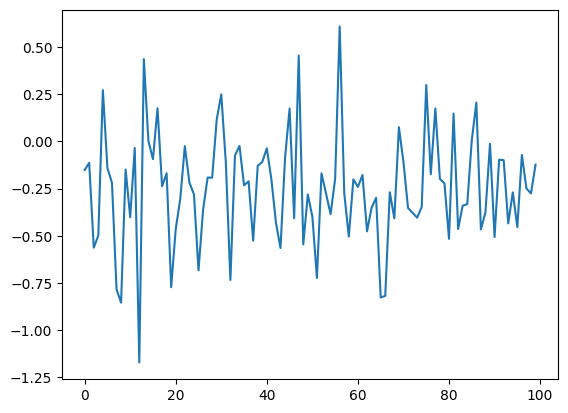

In [ ]:
df.loc[:,'feature_00'].reset_index(drop=True)[:100].plot()

<Axes: >

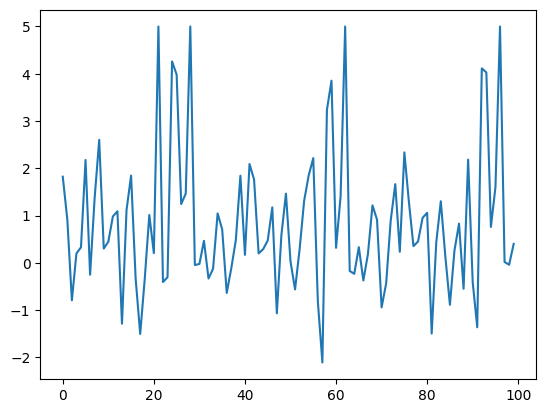

In [ ]:
df.loc[:,'responder_6'][:100].plot()

In [5]:
# # feature 컬럼 선택
# feature_cols = df.columns[df.columns.str.contains('feature')].tolist()

# # 날짜 정렬 및 인덱스 설정
# df = df.sort_values('date_id')

# # 모든 feature 컬럼에 대해 한번에 계산
# means_by_date = df.groupby('date_id')[feature_cols].mean()

# # 이전 날짜의 평균값들을 shift해서 한번에 계산
# shifted_means = means_by_date.shift(1)

# # 각 행의 date_id에 해당하는 이전 평균값을 매핑
# for feature_col in feature_cols:
#     new_col_name = f"{feature_col}_universe_mean_window_1"
#     df[new_col_name] = df[feature_col] - df['date_id'].map(shifted_means[feature_col])

In [6]:
# import numpy as np
# import pandas as pd

# def split_into_deciles(df):
#     # 작업할 데이터프레임 복사
#     result_df = df.copy()
#     decile_bounds = {}
    
#     feature_columns = df.columns.str.contains('feature')
#     responder_columns = df.columns.str.contains('responder')
    
#     # 각 컬럼에 대해 처리
#     for column_name in df.columns[feature_columns+responder_columns]:
#         # 유니크한 값의 개수 확인
#         unique_values = df[column_name].nunique()
        
#         if unique_values < 10:
#             # 유니크한 값이 10개 미만인 경우, 가능한 최대 분위수로 조정
#             n_quantiles = min(unique_values, 10)
#             labels = [i for i in range(1, n_quantiles)]  # 레이블 개수를 하나 줄임
            
#             try:
#                 # 분위수 계산 및 qcut 적용
#                 result_df[column_name] = pd.qcut(df[column_name],
#                                                q=n_quantiles-1,  # 구간 개수를 하나 줄임
#                                                labels=labels,
#                                                duplicates='drop')
                
#                 # 실제 경계값 계산
#                 quantiles = np.percentile(df[column_name], 
#                                         np.linspace(0, 100, n_quantiles))
                
#                 # 경계값 저장
#                 decile_bounds[column_name] = {
#                     f'{i}': f'{quantiles[i-1]:.2f} ~ {quantiles[i]:.2f}'
#                     for i in range(1, n_quantiles)
#                 }
                
#             except ValueError as e:
#                 # 분할이 불가능한 경우 원본 값 유지
#                 print(f"Warning: Could not split column {column_name} into quantiles. Error: {e}")
#                 result_df[column_name] = df[column_name]
#                 decile_bounds[column_name] = {"1": "Original values retained"}
            
#         else:
#             # 10개 이상의 유니크한 값이 있는 경우 9개의 구간으로 나눔(10분위수)
#             try:
#                 labels = [i for i in range(1, 10)]  # 9개의 레이블
                
#                 # qcut 적용
#                 result_df[column_name] = pd.qcut(df[column_name],
#                                                q=9,  # 9개 구간
#                                                labels=labels,
#                                                duplicates='drop')
                
#                 # 실제 경계값 계산
#                 quantiles = np.percentile(df[column_name], 
#                                         np.linspace(0, 100, 10))
                
#                 # 경계값 저장
#                 decile_bounds[column_name] = {
#                     f'{i}': f'{quantiles[i-1]:.2f} ~ {quantiles[i]:.2f}'
#                     for i in range(1, 10)
#                 }
                
#             except ValueError as e:
#                 print(f"Warning: Could not split column {column_name} into quantiles. Error: {e}")
#                 result_df[column_name] = df[column_name]
#                 decile_bounds[column_name] = {"1": "Original values retained"}
    
#     return result_df, decile_bounds

# result_df, decile_bounds = split_into_deciles(df)

In [7]:
corr_matrix = df.corr()

In [8]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

def cluster_from_correlation(corr_mat, n_clusters=5, figsize=(15, 10)):
    """
    상관계수 행렬을 기반으로 특성들을 클러스터링하고 클러스터별로 색상을 구분하여 시각화합니다.
    """
    
    # 상관계수 행렬을 거리 행렬로 변환 (1 - |상관계수|)
    distance_matrix = 1 - np.abs(corr_mat)
    
    # 계층적 클러스터링 수행
    linkage_matrix = linkage(distance_matrix.values, method='ward')
    
    # 클러스터 레이블 생성
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # 결과를 데이터프레임으로 정리
    cluster_df = pd.DataFrame({
        'feature': corr_mat.index,
        'cluster': cluster_labels
    })
    
    # 클러스터별 색상 지정
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    cluster_colors = dict(zip(range(1, n_clusters + 1), colors))
    
    # 각 feature에 대한 색상 매핑
    feature_colors = {row['feature']: cluster_colors[row['cluster']] 
                     for _, row in cluster_df.iterrows()}
    
    
    def leaf_color_func(k):
        return mcolors.rgb2hex(feature_colors[corr_mat.index[k]])
    

    
    # 클러스터 순서대로 정렬
    ordered_features = cluster_df.sort_values('cluster')['feature']
    

    

    
    # 클러스터별 특성 출력
    print("\nClustering Results:")
    for i in range(1, n_clusters + 1):
        features = cluster_df[cluster_df['cluster'] == i]['feature'].tolist()
        
        # 클러스터 내 평균 상관계수 계산
        cluster_corr = corr_mat.loc[features, features]
        mean_corr = cluster_corr.values[np.triu_indices_from(cluster_corr.values, k=1)].mean()
        if abs(mean_corr) > 0.3:    
            print(f"\nCluster {i} ({len(features)} features):")
            print(f"Features: {', '.join(features)}")
            print(f"Average internal correlation: {mean_corr:.3f}")
    
    return cluster_df

# 클러스터링 수행
n_clusters = 30  # 원하는 클러스터 수
cluster_results = cluster_from_correlation(corr_matrix, n_clusters=n_clusters)

# 특정 클러스터의 특성 확인
cluster_1_features = cluster_results[cluster_results['cluster'] == 1]['feature']
print("\nCluster 1 features:", cluster_1_features.tolist())



Clustering Results:

Cluster 1 (3 features):
Features: feature_13, feature_68, feature_71
Average internal correlation: 0.688

Cluster 2 (6 features):
Features: feature_12, feature_14, feature_67, feature_69, feature_70, feature_72
Average internal correlation: 0.755

Cluster 3 (2 features):
Features: feature_45, feature_56
Average internal correlation: 0.854

Cluster 4 (2 features):
Features: feature_19, feature_66
Average internal correlation: 0.809

Cluster 5 (2 features):
Features: feature_18, feature_65
Average internal correlation: 0.798

Cluster 6 (2 features):
Features: feature_46, feature_57
Average internal correlation: 0.852

Cluster 7 (2 features):
Features: feature_37, feature_38
Average internal correlation: 0.848

Cluster 8 (2 features):
Features: feature_39, feature_50
Average internal correlation: 0.743

Cluster 9 (3 features):
Features: feature_41, feature_51, feature_52
Average internal correlation: 0.379

Cluster 10 (4 features):
Features: feature_42, feature_44, f

/tmp/ipykernel_268844/3883814411.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix.values, method='ward')
/tmp/ipykernel_268844/3883814411.py:56: RuntimeWarning: Mean of empty slice.
  mean_corr = cluster_corr.values[np.triu_indices_from(cluster_corr.values, k=1)].mean()
/home/luke/anaconda3/envs/rl4trading/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
def get_high_correlation_pairs(corr_mat, threshold=0.3):
    # 대각선의 상삼각 행렬만 선택 (중복 제거)
    upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    
    # threshold 이상인 값들을 찾아서 데이터프레임으로 변환
    high_corr = upper_tri.unstack()
    high_corr = high_corr[abs(high_corr) >= threshold]
    
    # Series를 데이터프레임으로 변환하고 컬럼명 지정
    high_corr_df = pd.DataFrame(high_corr).reset_index()
    high_corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # 상관계수 절대값 기준으로 정렬
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    return high_corr_df

high_corr_mat = get_high_correlation_pairs(corr_matrix)

In [10]:
high_corr_mat['Feature 1'].str.contains('responder').sum()

np.int64(13)

In [11]:
high_corr_mat

,Feature 1,Feature 2,Correlation
61,feature_31,feature_21,0.965308
308,feature_76,feature_75,0.956412
317,feature_78,feature_77,0.955845
303,feature_74,feature_73,0.954443
18,feature_17,feature_15,0.939833
...,...,...,...
0,feature_00,date_id,0.302575
33,feature_24,feature_15,-0.301554
17,feature_17,feature_10,0.301307
57,feature_30,feature_24,-0.300734


In [12]:
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,1020,0,0,2.679878,-0.151614,-1.218194,-0.584913,-0.129442,1.564324,0.367270,...,-0.315150,0.057490,-0.020380,0.151817,1.176065,-0.683896,1.222135,1.822080,-0.699136,2.865153
1,1020,0,1,4.407496,-0.114243,-1.553200,-0.438179,0.147782,1.686174,0.283562,...,-0.328378,-0.214946,-0.036094,-0.036046,0.525263,-0.434739,1.235148,0.914796,-0.717382,0.643339
2,1020,0,2,2.821721,-0.563401,-1.109032,-0.146964,-0.112394,1.528836,0.460348,...,-0.150332,-0.441242,-0.281995,0.155182,-1.106123,-0.771560,-0.464858,-0.793521,-0.717857,-1.547887
3,1020,0,3,1.700922,-0.499214,-0.807310,0.037185,0.256615,1.996381,0.208247,...,1.049820,0.246010,0.362785,0.000741,0.304133,-0.598776,0.545253,0.198089,-1.289874,0.688991
4,1020,0,4,2.232697,0.271390,-1.067931,-0.073194,0.355548,1.794548,0.136368,...,0.725878,-0.473040,-0.140053,-1.146351,0.145259,-0.030338,-1.370866,0.328847,0.035067,-1.773254


In [14]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def cluster_symbols(df, n_clusters=5):
    # 데이터 전처리
    # StandardScaler로 각 시계열을 정규화
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(
        scaler.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    
    # 상관계수 행렬 계산
    corr_matrix = scaled_df.corr()
    
    # 상관계수를 거리로 변환 (1 - 상관계수)
    distance_matrix = 1 - np.abs(corr_matrix)
    
    # 계층적 클러스터링 수행
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # 클러스터 레이블 생성
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # 결과를 데이터프레임으로 정리
    cluster_df = pd.DataFrame({
        'symbol': corr_matrix.index,
        'cluster': cluster_labels
    })
    
    # 시각화
    plt.figure(figsize=(15, 10))
    
    # 덴드로그램
    plt.subplot(2, 1, 1)
    dendrogram(linkage_matrix, labels=corr_matrix.index, leaf_rotation=90)
    plt.title('Symbol Clustering Dendrogram')
    plt.xlabel('Symbols')
    plt.ylabel('Distance')
    
    # 히트맵
    plt.subplot(2, 1, 2)
    # 클러스터 순서대로 정렬
    ordered_idx = cluster_df.sort_values('cluster').index
    sns.heatmap(corr_matrix.iloc[ordered_idx, ordered_idx], 
                cmap='RdYlBu_r', 
                center=0,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    
    plt.title('Correlation Heatmap (Ordered by Clusters)')
    plt.tight_layout()
    plt.show()
    
    
    return cluster_df

# 사용 예시:
# 클러스터링 수행
n_clusters = 7  # 원하는 클러스터 수 지정
cluster_results = cluster_symbols(responder_df, n_clusters=n_clusters)

# 결과 출력
print("\nClustering Results:")
for i in range(1, n_clusters + 1):
    symbols = cluster_results[cluster_results['cluster'] == i]['symbol'].tolist()
    print(f"\nCluster {i}:")
    print(f"Symbols: {', '.join(symbols)}")

NameError: name 'responder_df' is not defined

In [15]:
cluster_results = cluster_symbols(df.loc[:, df.columns.str.contains('feature')], n_clusters=n_clusters)


KeyboardInterrupt: 

In [ ]:
responder_df

In [ ]:
df.loc[df['symbol_id']==2].groupby(df['date_id']).mean()['feature_02'].plot()
df.groupby(df['date_id']).mean()['feature_02'].plot()

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_time_series(data, lags=[1,7,14,28], feature_name=""):
    """
    시계열 데이터의 자기상관성을 특정 lag에 대해서만 분석하는 함수
    
    Parameters:
    data: pandas Series or numpy array - 분석할 시계열 데이터
    lags: list or array-like - 분석하고자 하는 특정 lag 값들의 리스트 (예: [1,7,14,28])
    """
    
    # 데이터를 Series로 변환
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    
    data.dropna(inplace=True)
    
    # ACF 계산
    acf_values = acf(data, nlags=max(lags))
    selected_acf = [acf_values[lag] for lag in lags]
    
    # 시각화
    plt.figure(figsize=(10, 6))
    x_positions = range(len(lags))  # x축 위치를 0부터 순서대로 설정
    
    plt.bar(x_positions, selected_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='r', label='95% Confidence Interval')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='r')
    plt.title(f'Autocorrelation Function (ACF) for Selected Lags: {feature_name}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    
    # x축 눈금 설정 - 선택된 lag 값들만 표시
    plt.xticks(x_positions, lags)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return pd.Series(selected_acf, index=lags)

In [4]:
symbol_df = df[df['symbol_id']==1]

<Axes: xlabel='date_id'>

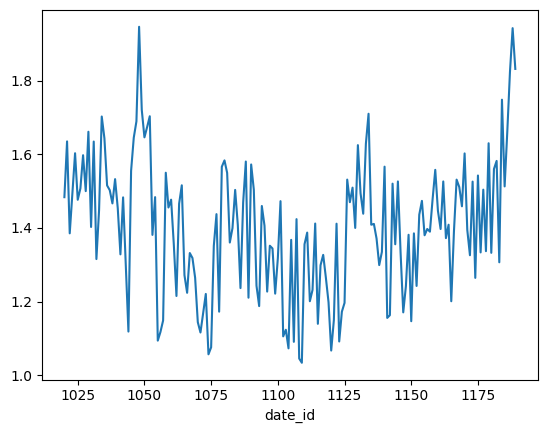

In [10]:
np.log(symbol_df.groupby("date_id").last()["weight"]).plot()

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


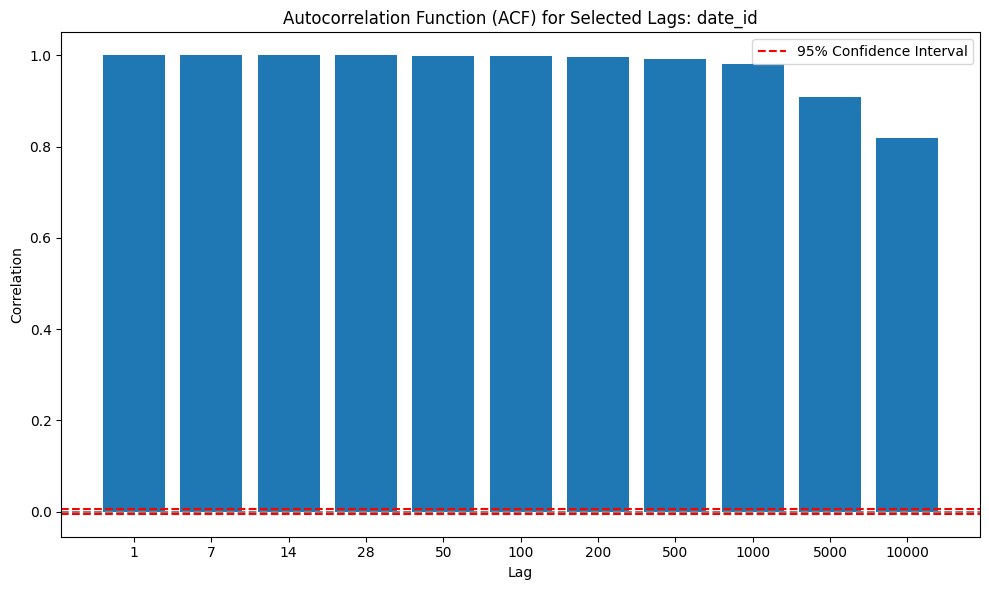

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


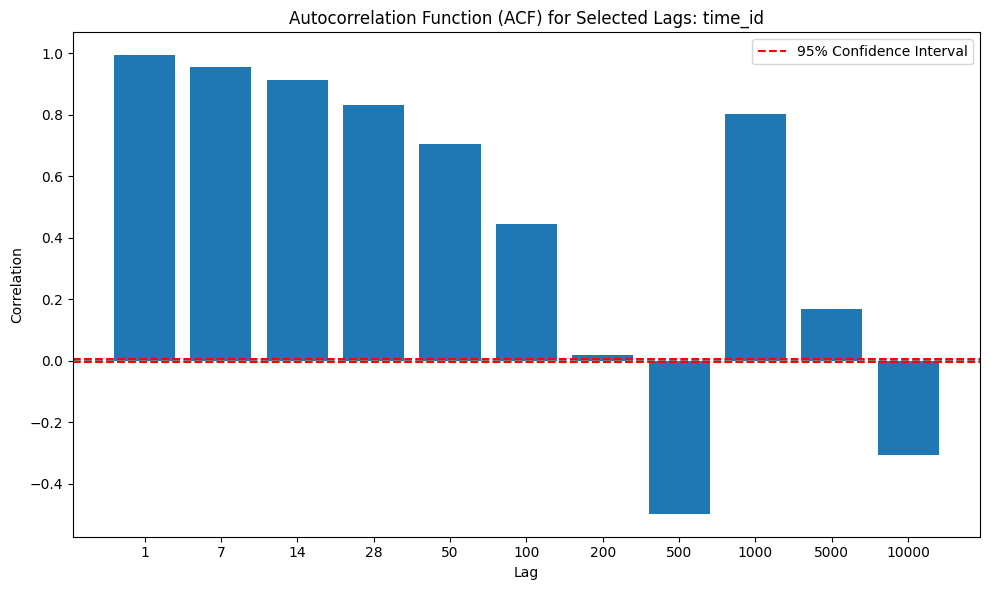

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/home/luke/anaconda3/envs/rl4trading/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


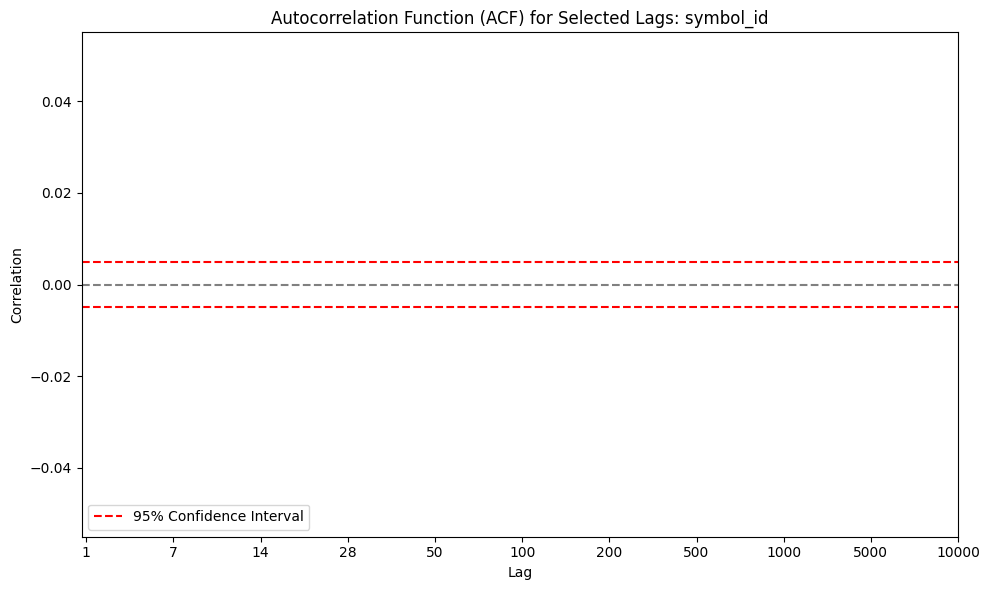

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


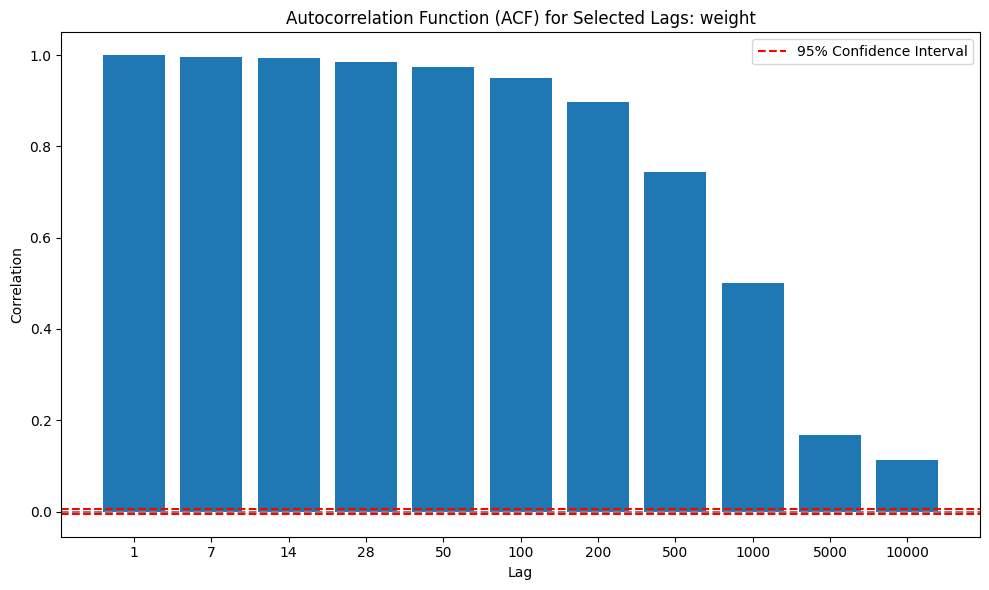

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


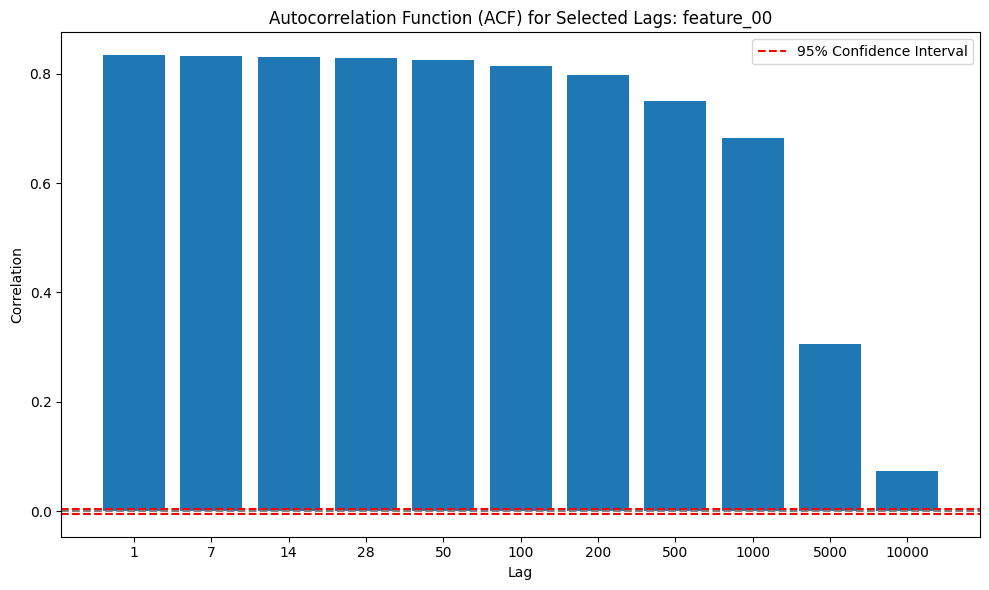

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


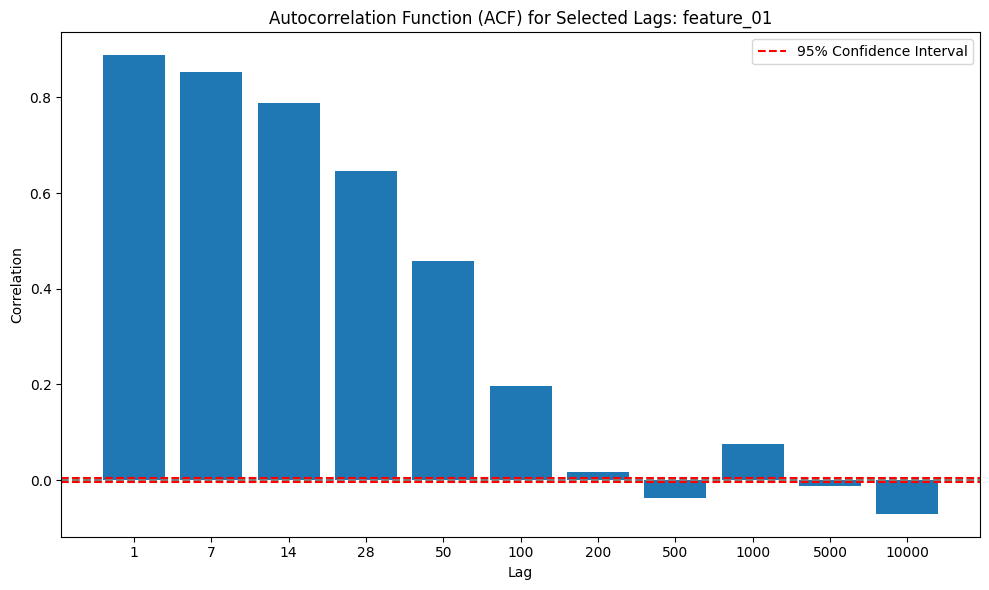

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


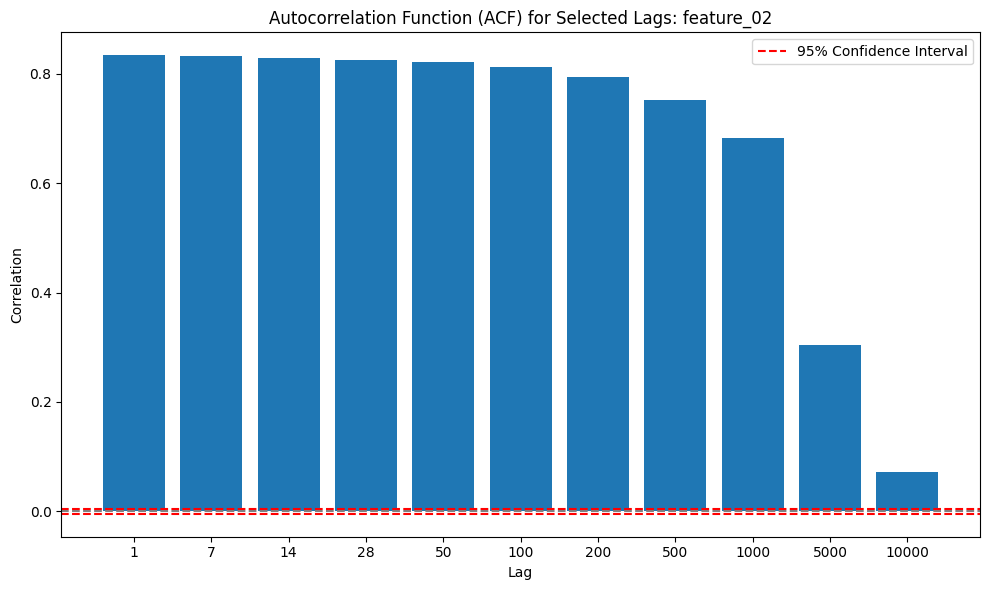

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


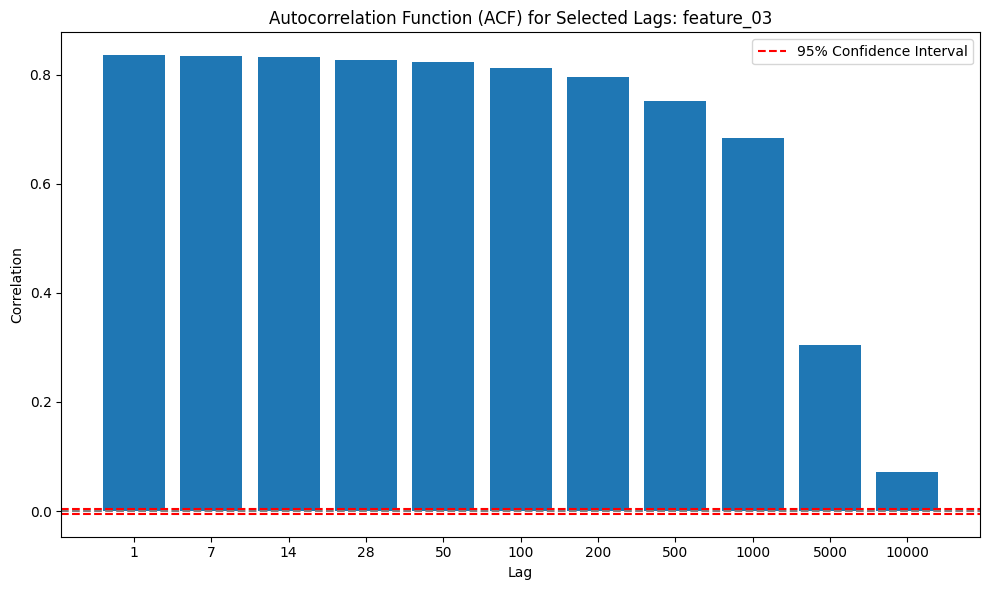

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


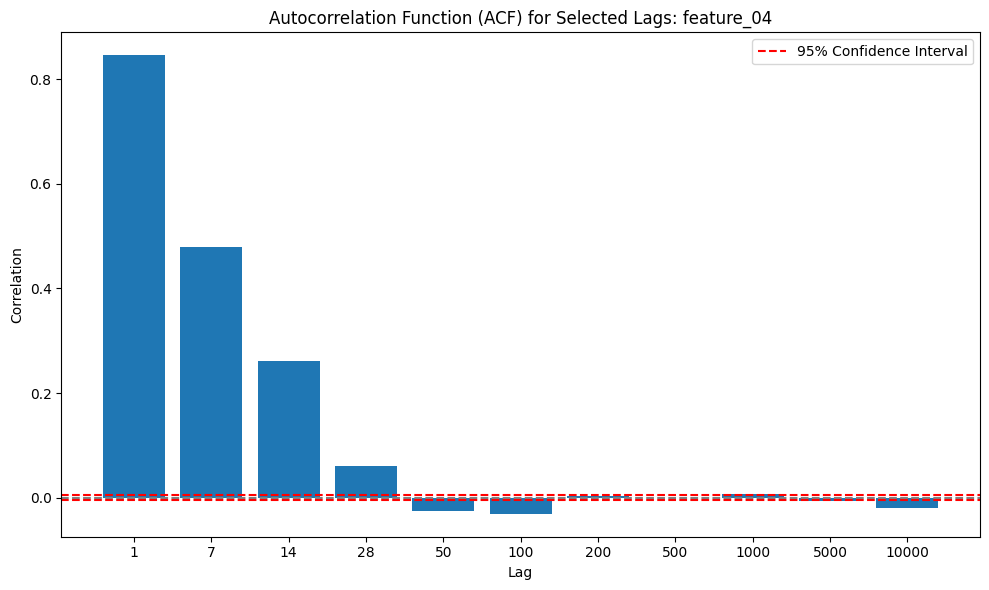

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


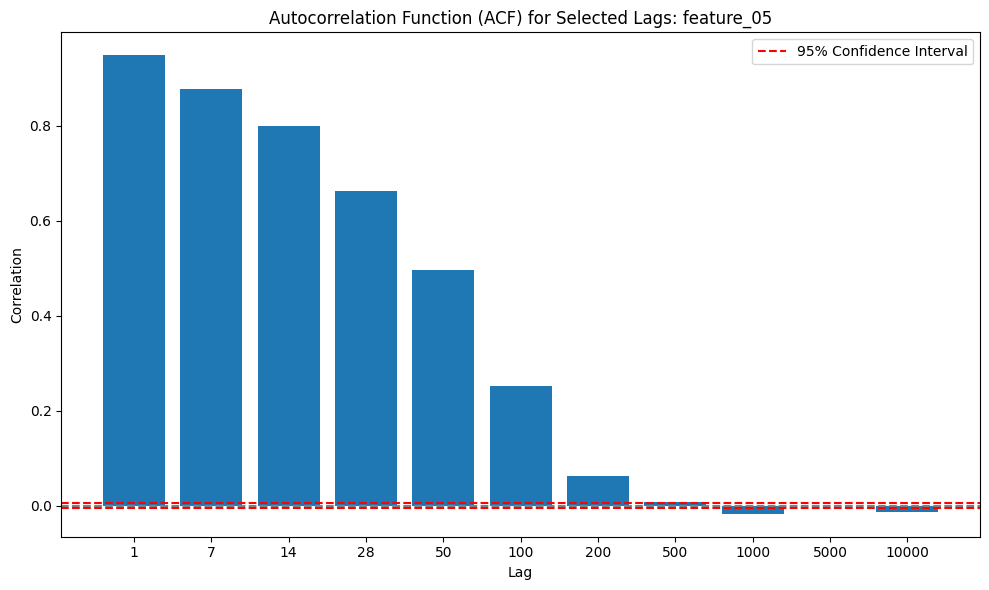

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


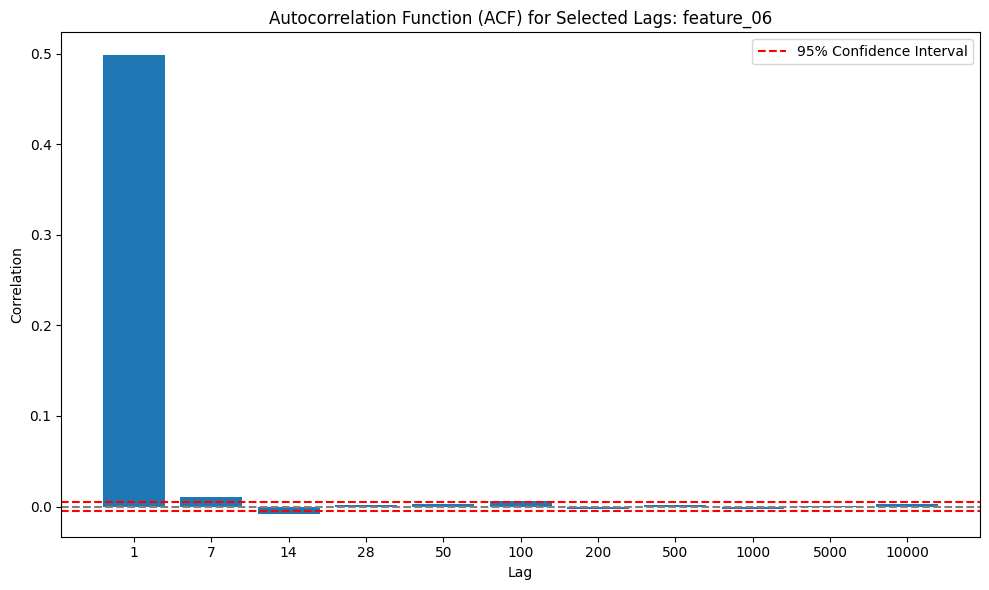

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


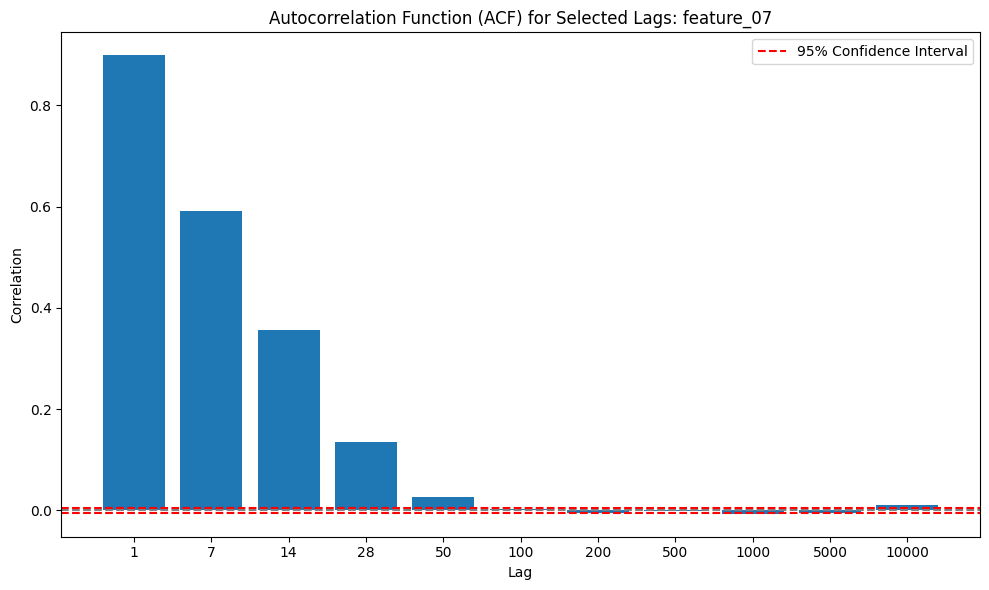

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


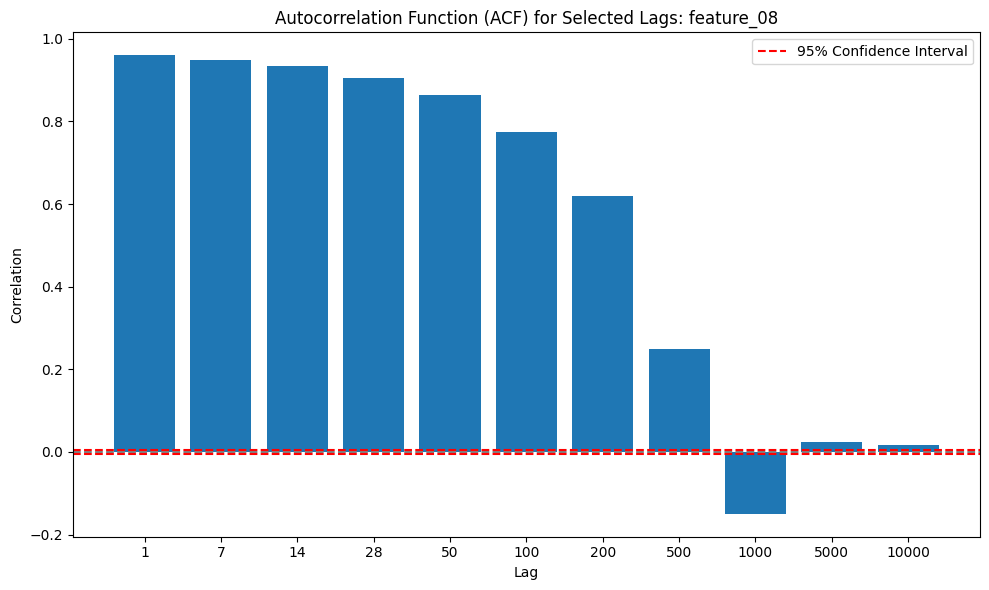

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/home/luke/anaconda3/envs/rl4trading/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


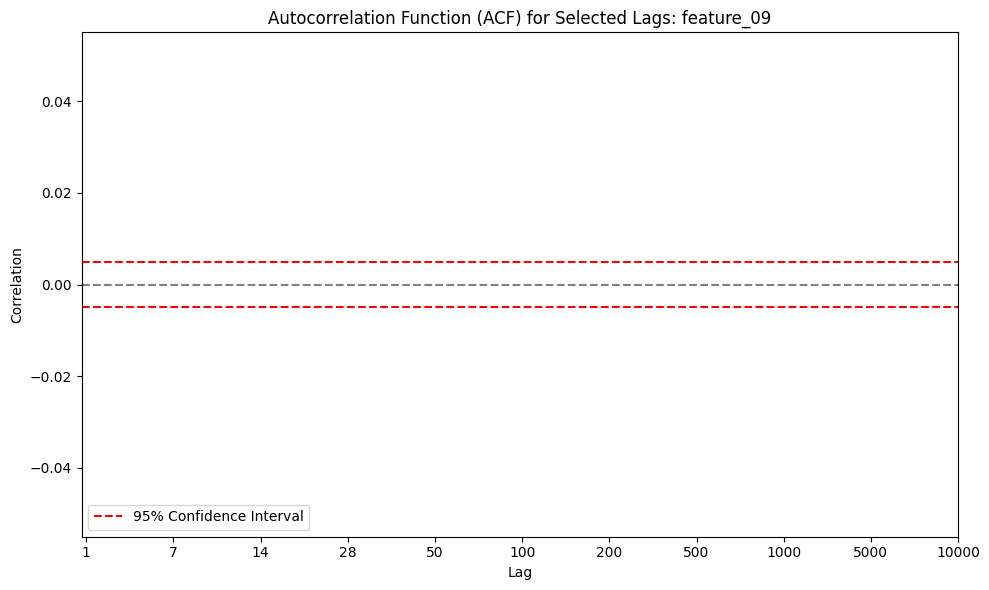

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/home/luke/anaconda3/envs/rl4trading/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


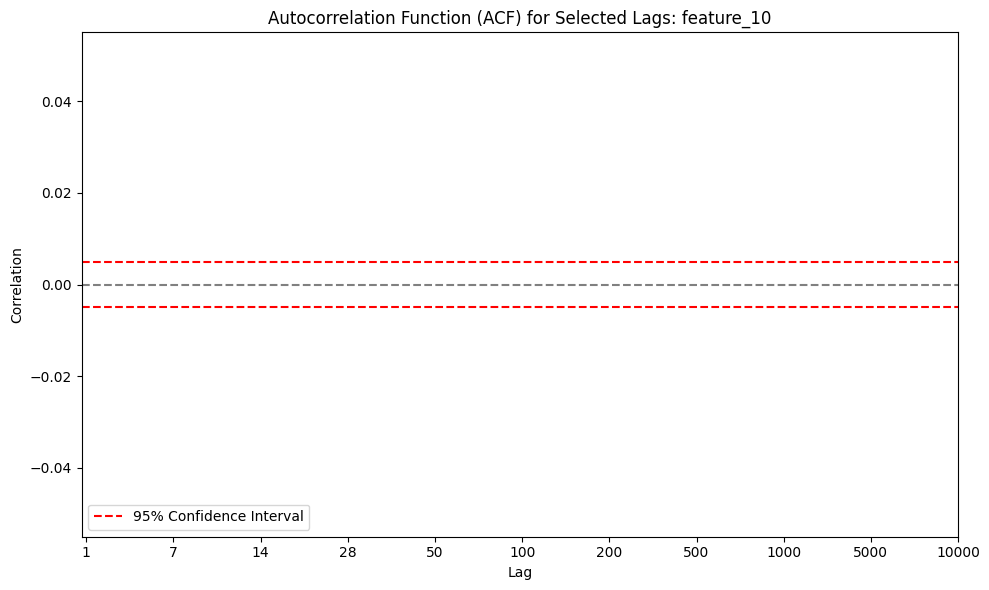

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/home/luke/anaconda3/envs/rl4trading/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


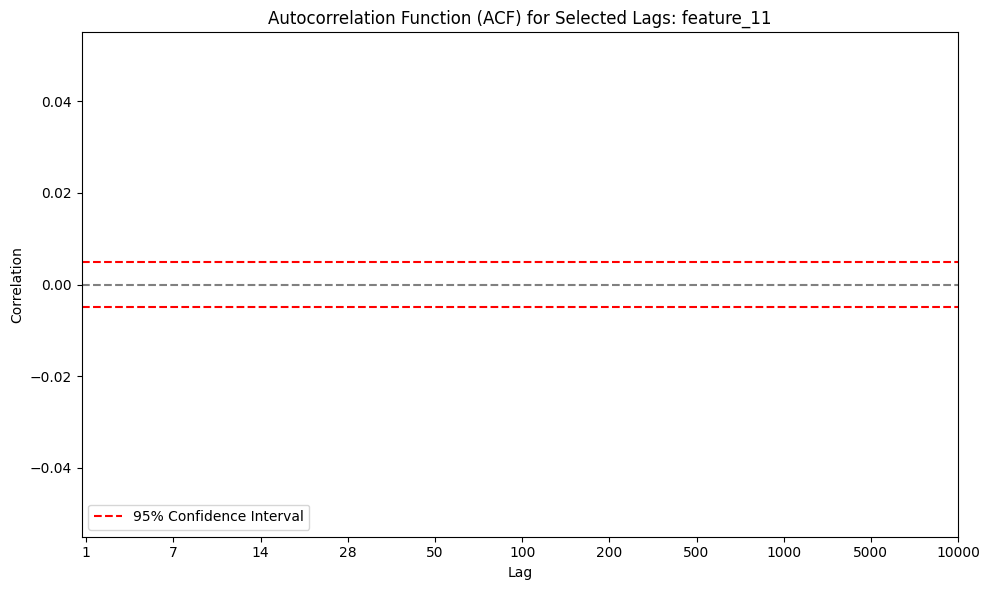

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


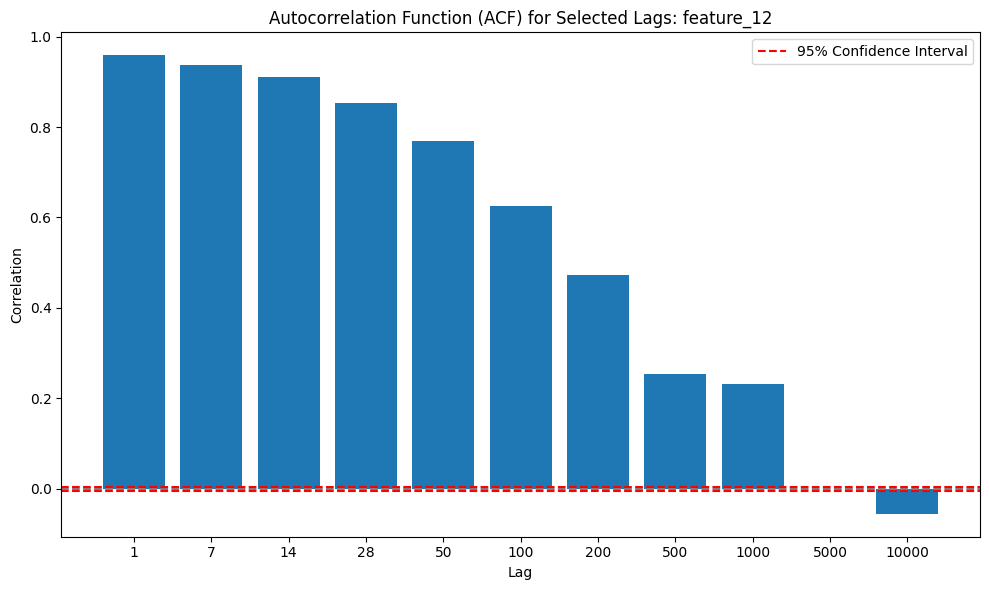

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


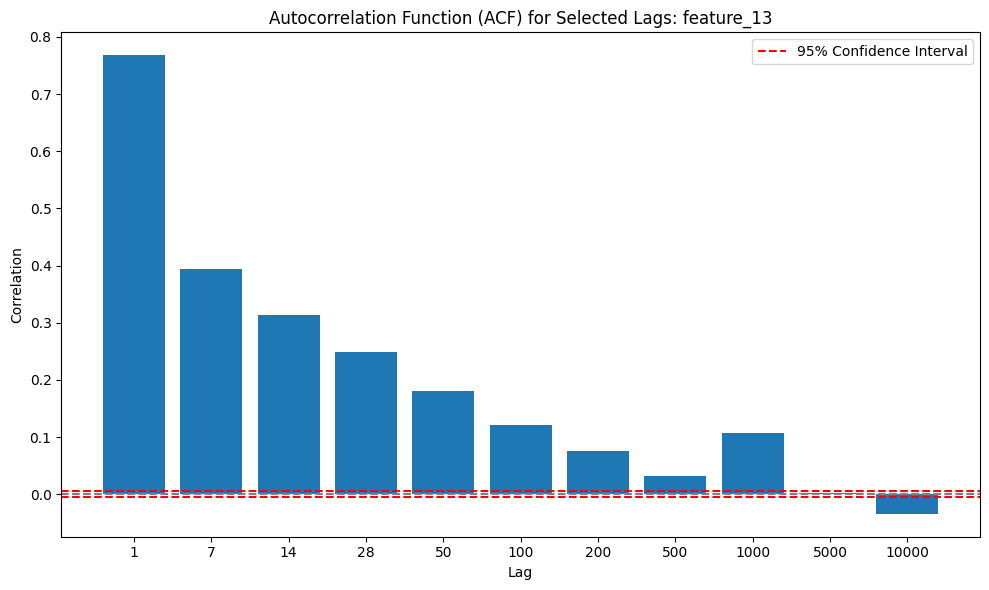

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


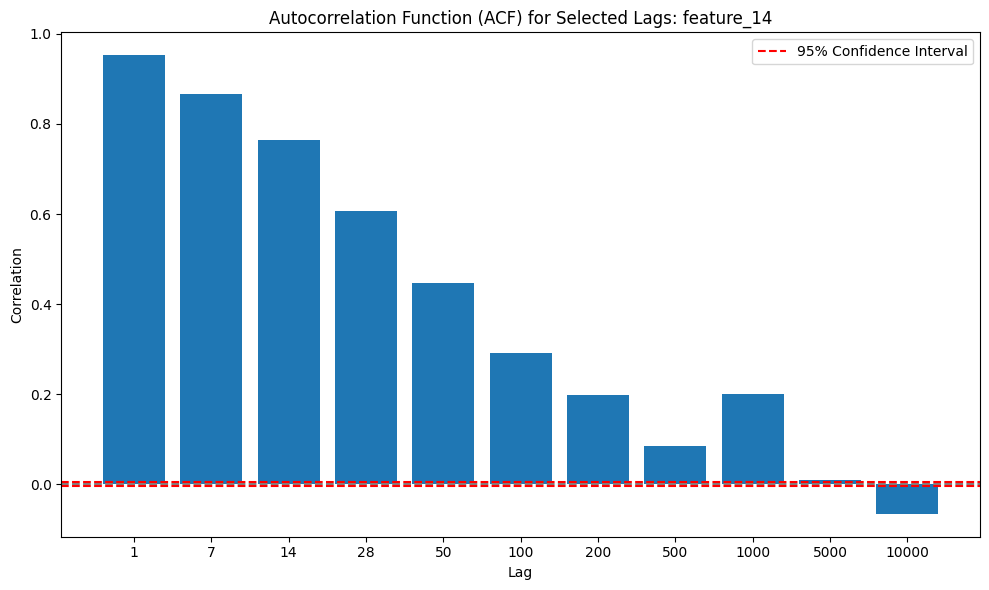

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


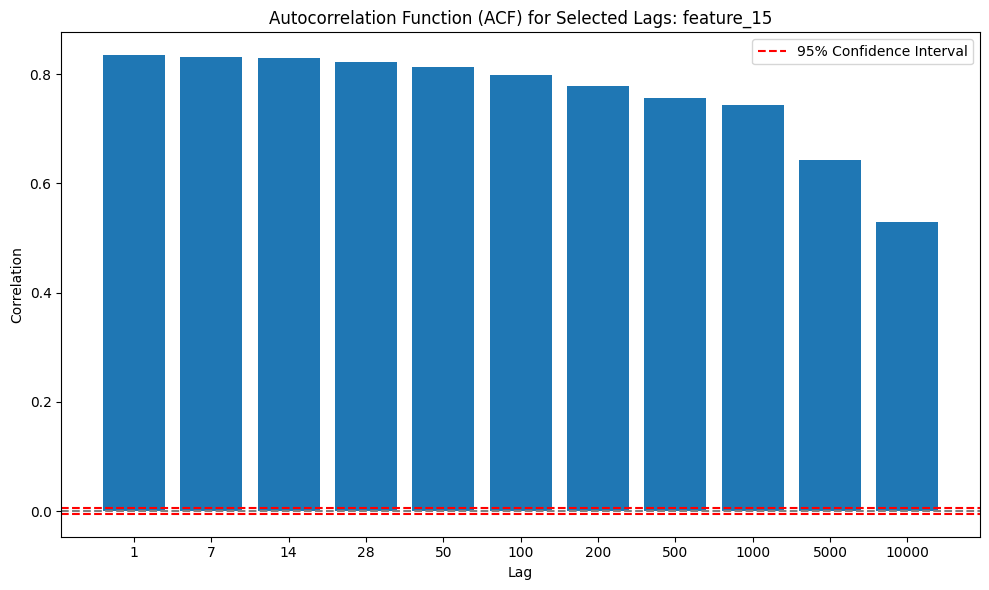

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


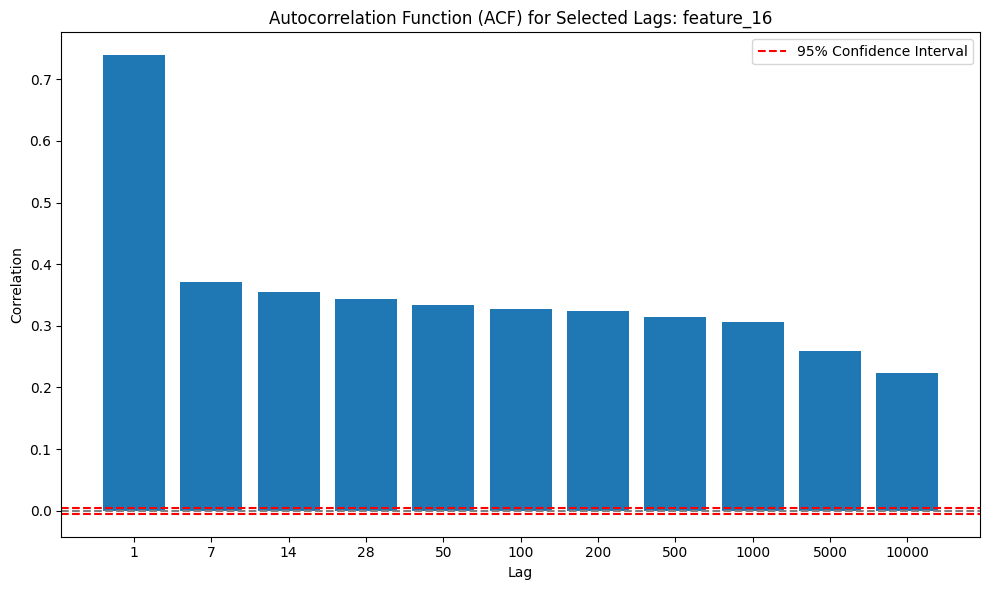

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


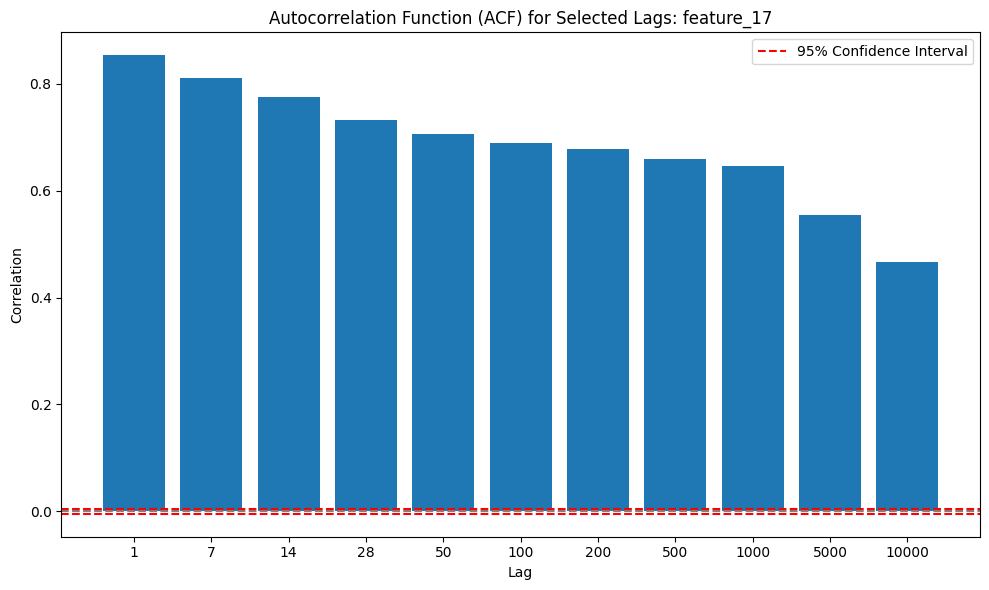

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


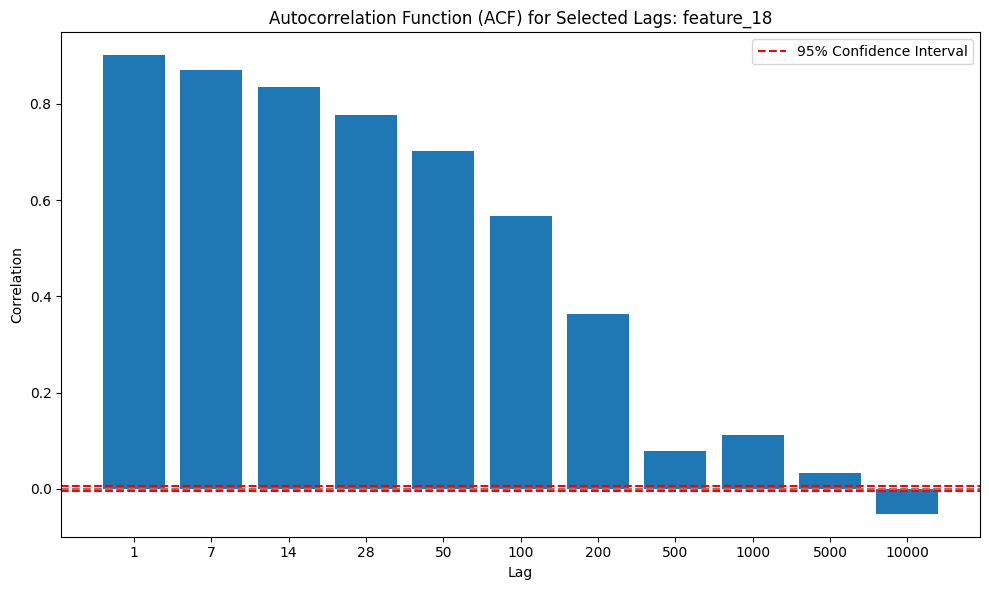

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


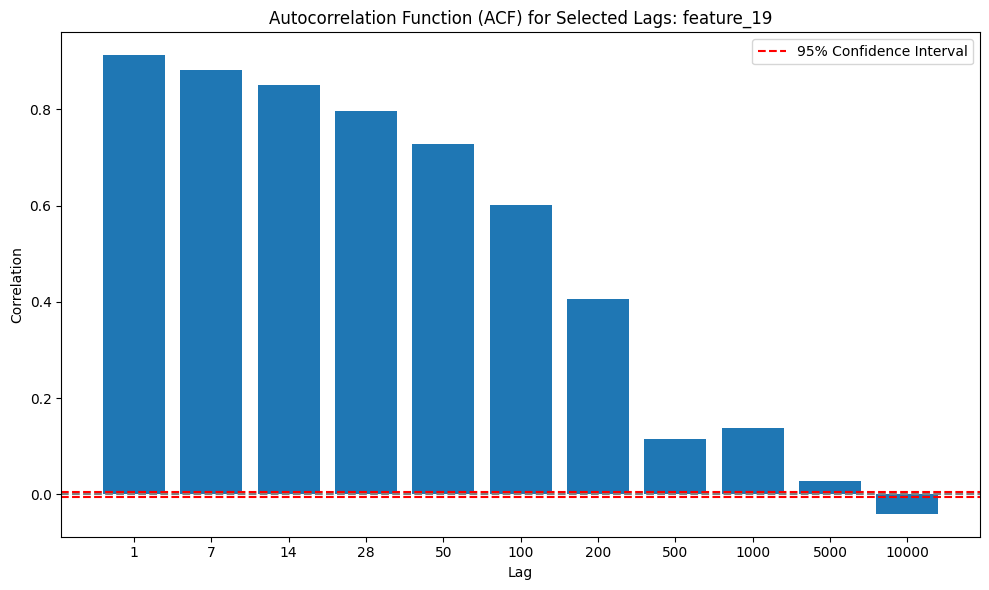

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


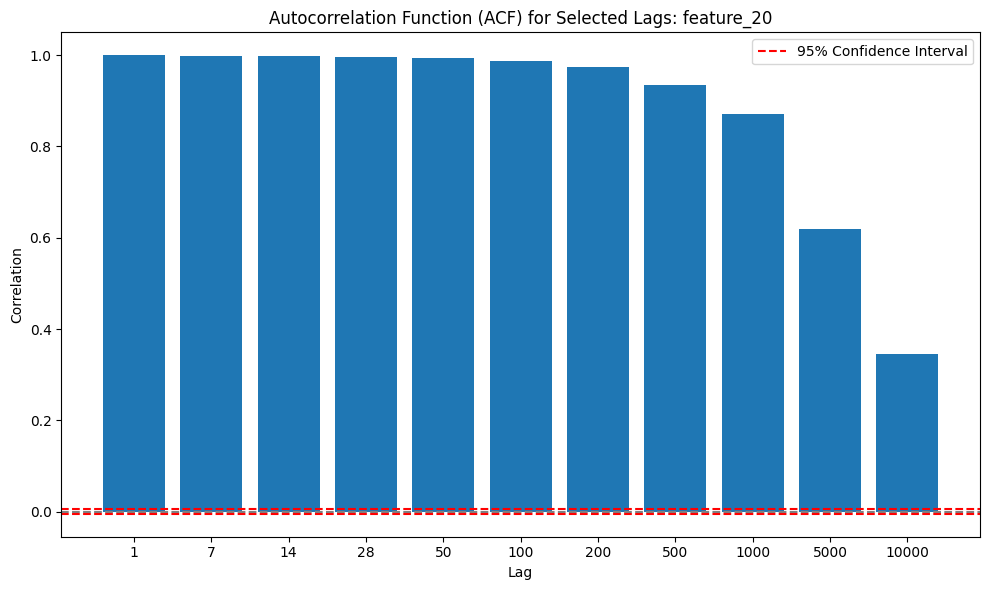

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


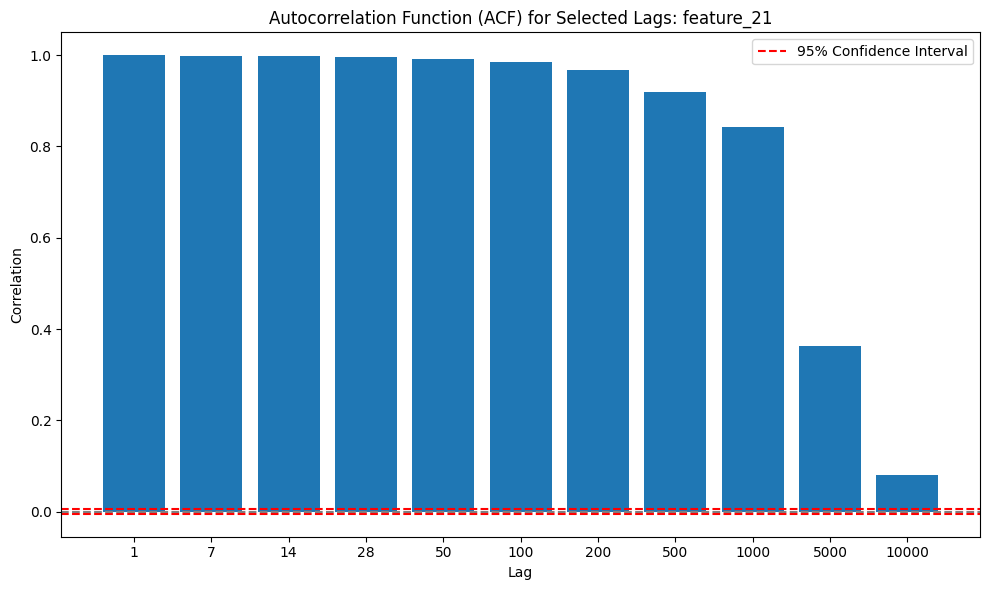

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


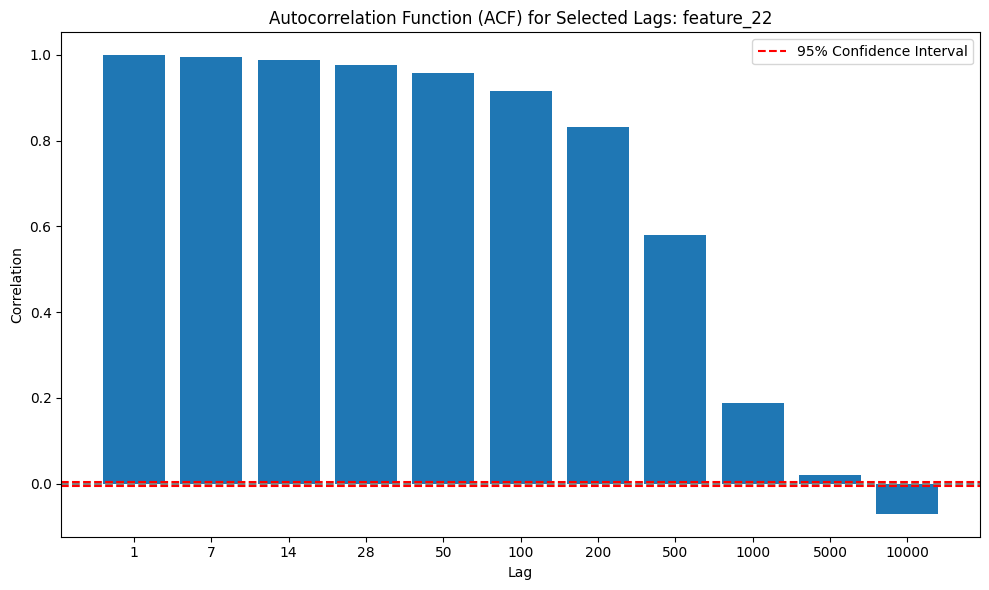

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


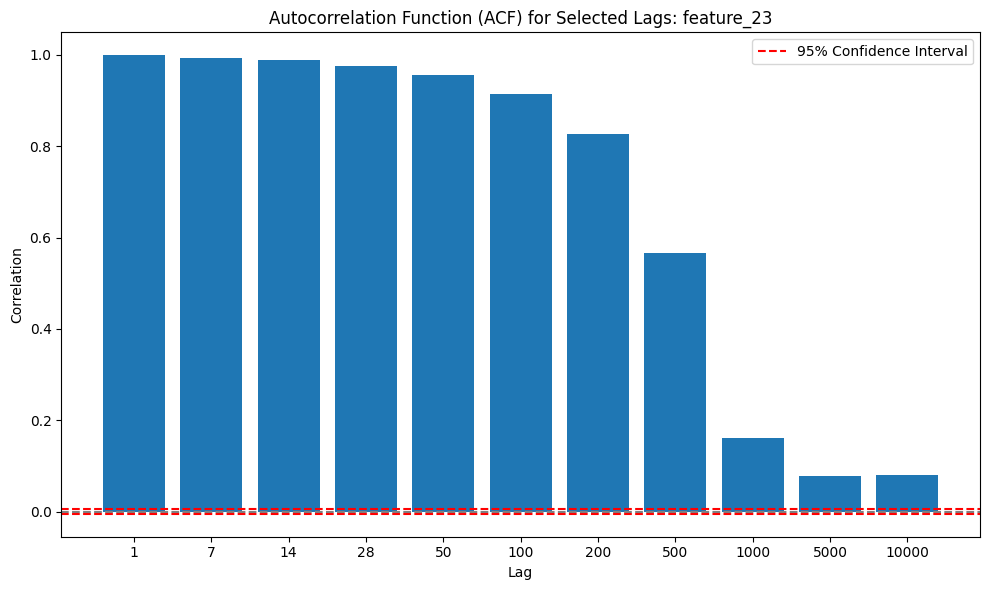

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


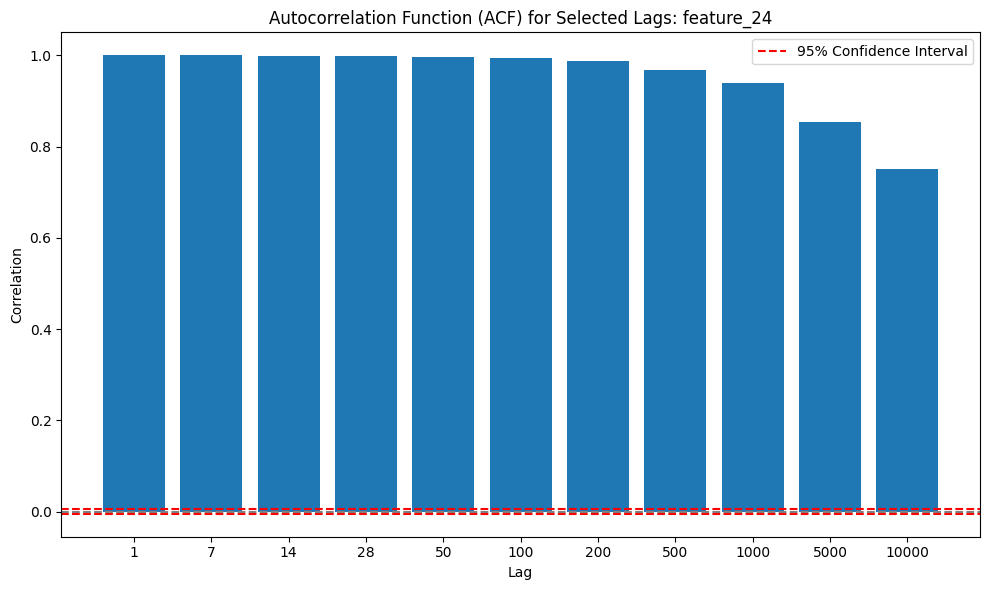

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


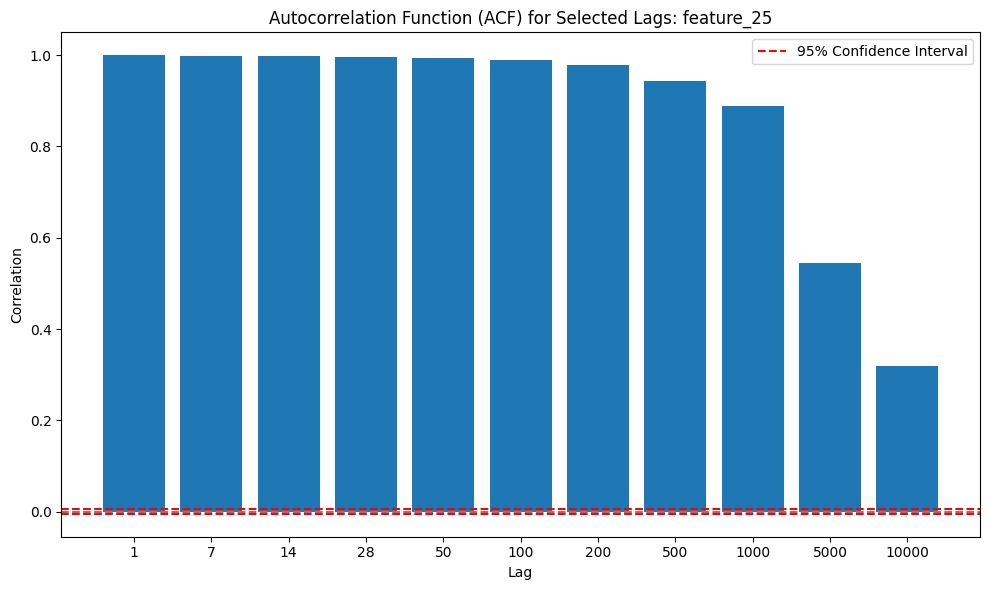

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


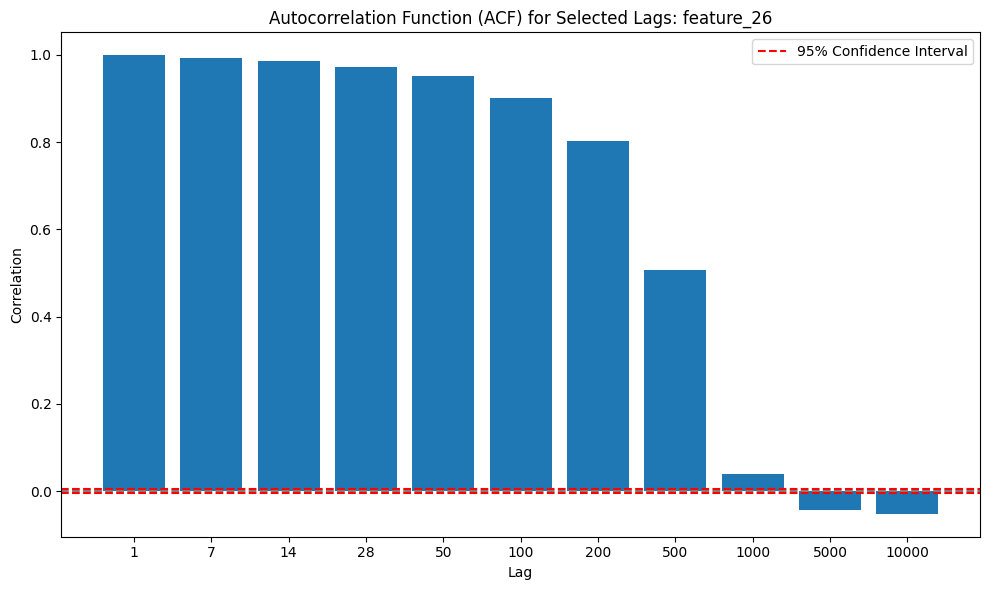

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


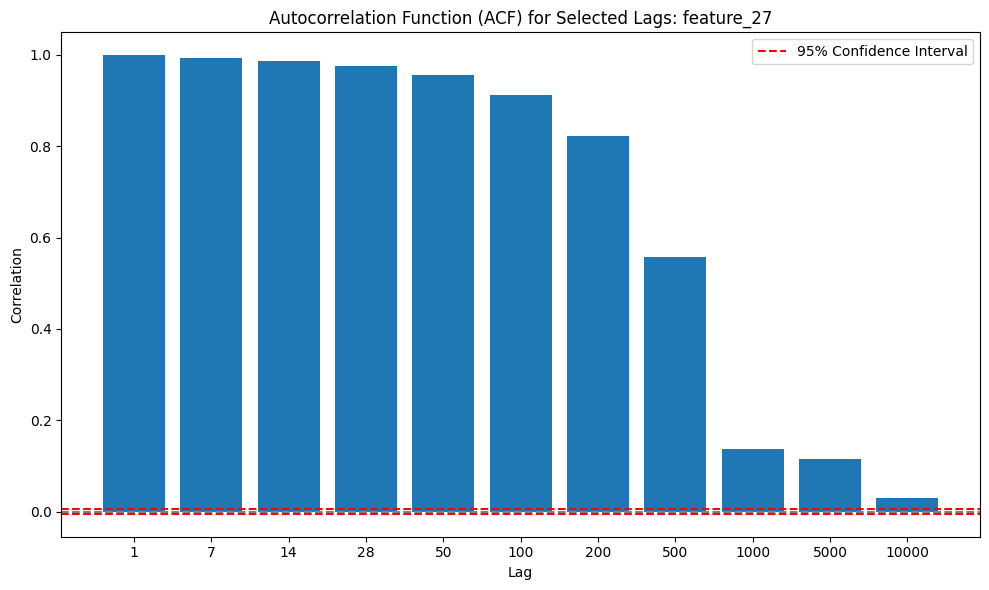

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


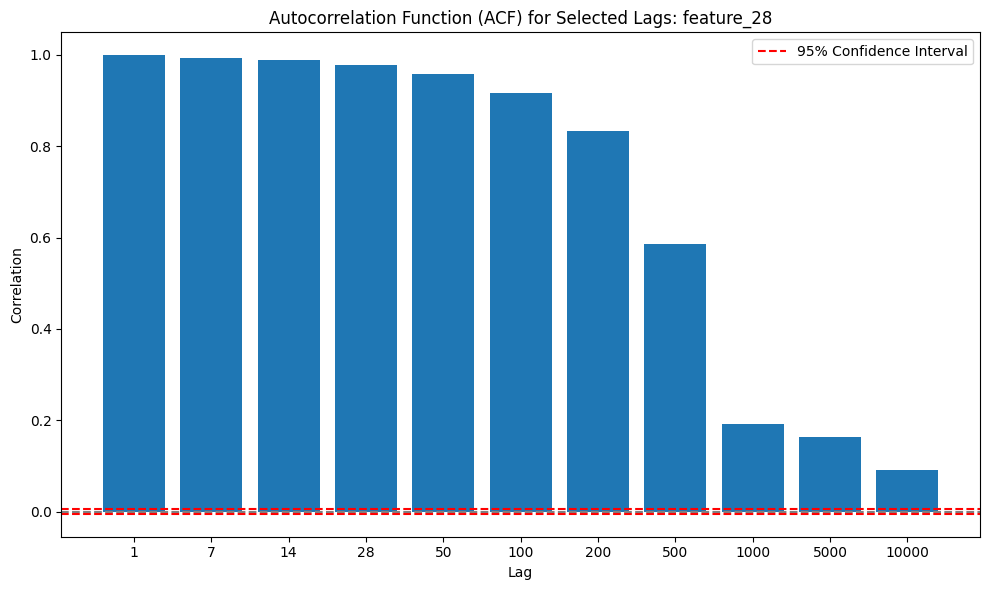

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


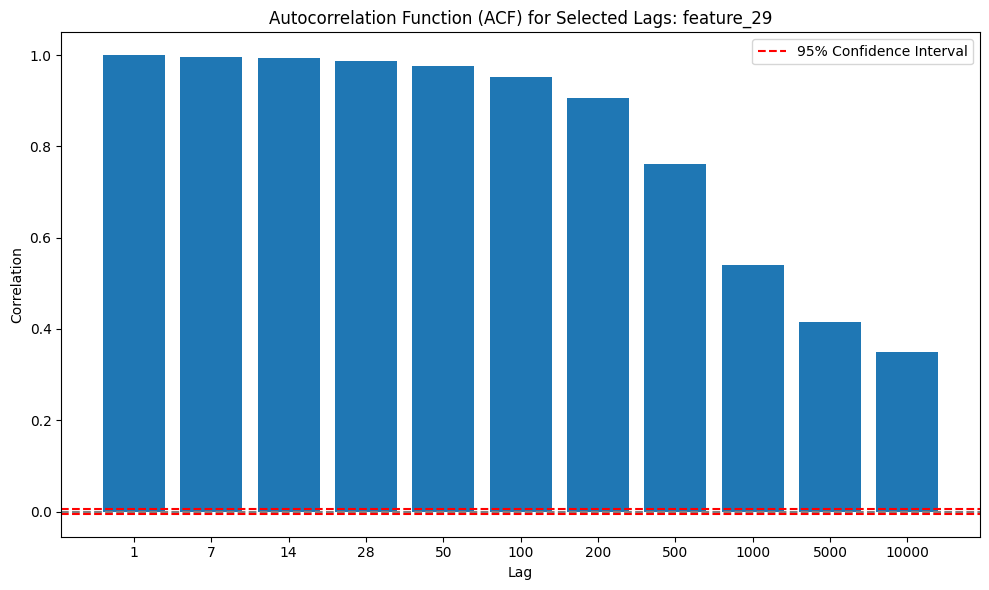

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


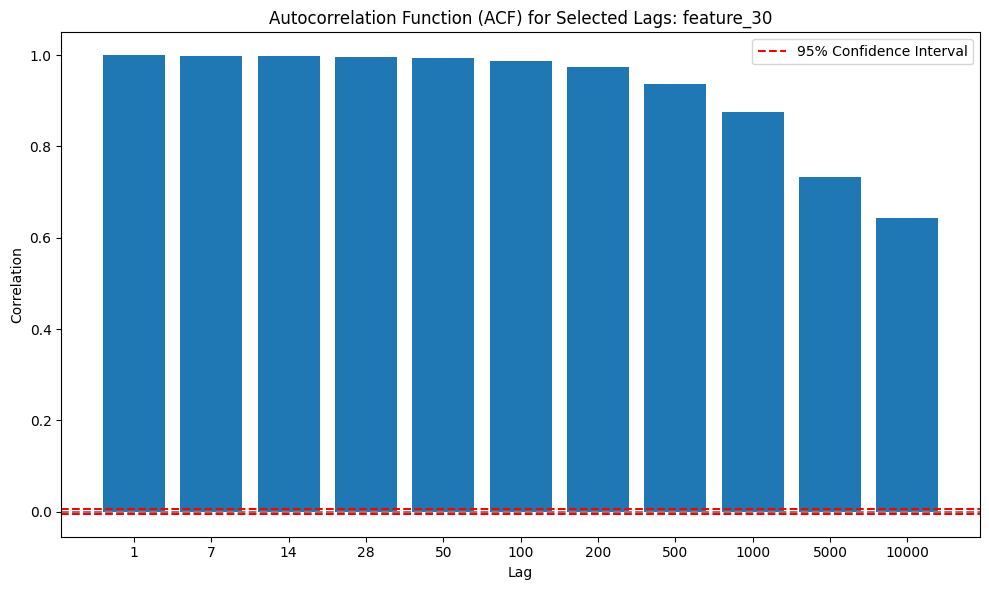

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


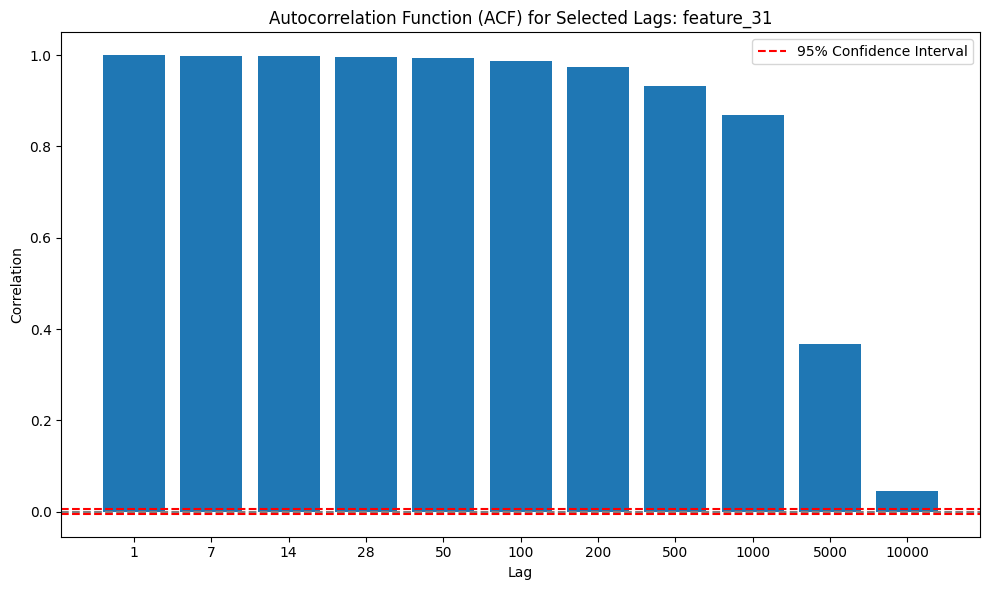

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


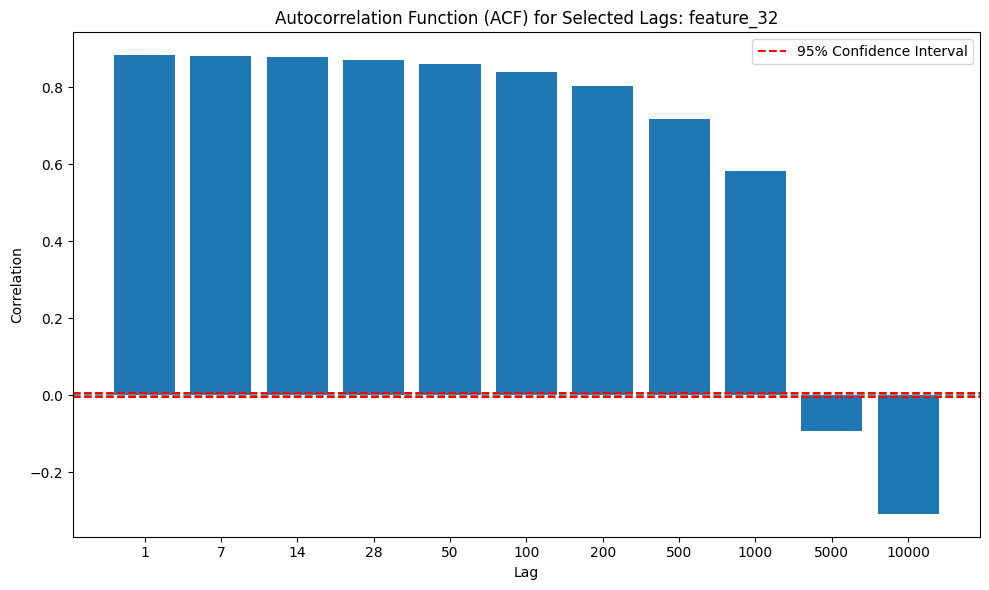

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


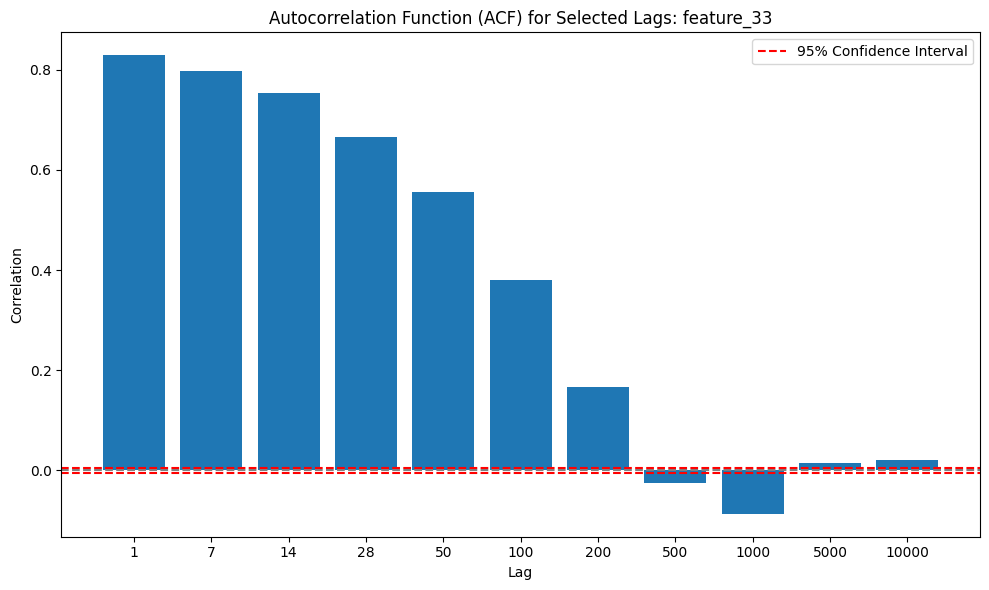

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


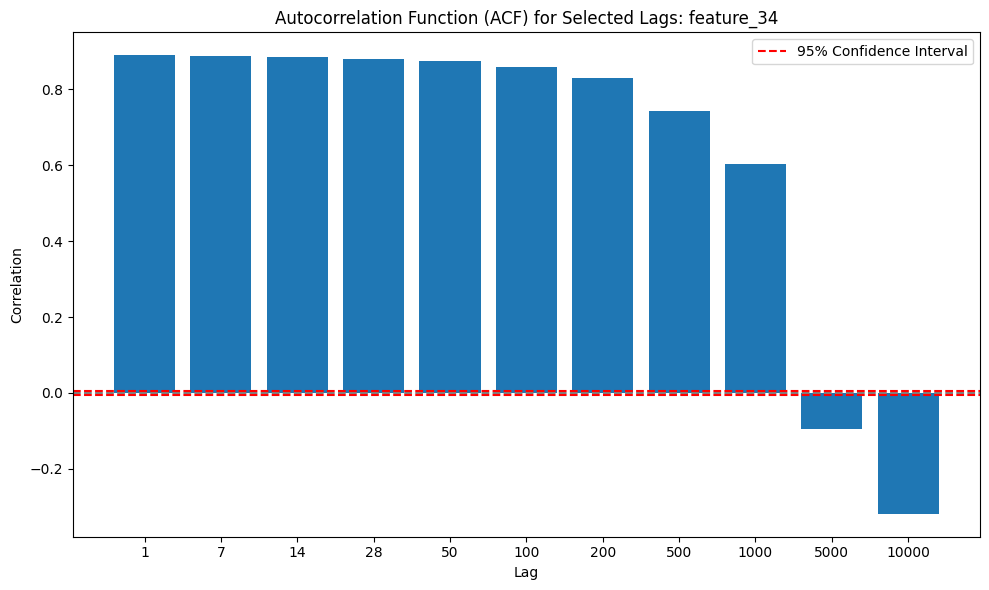

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


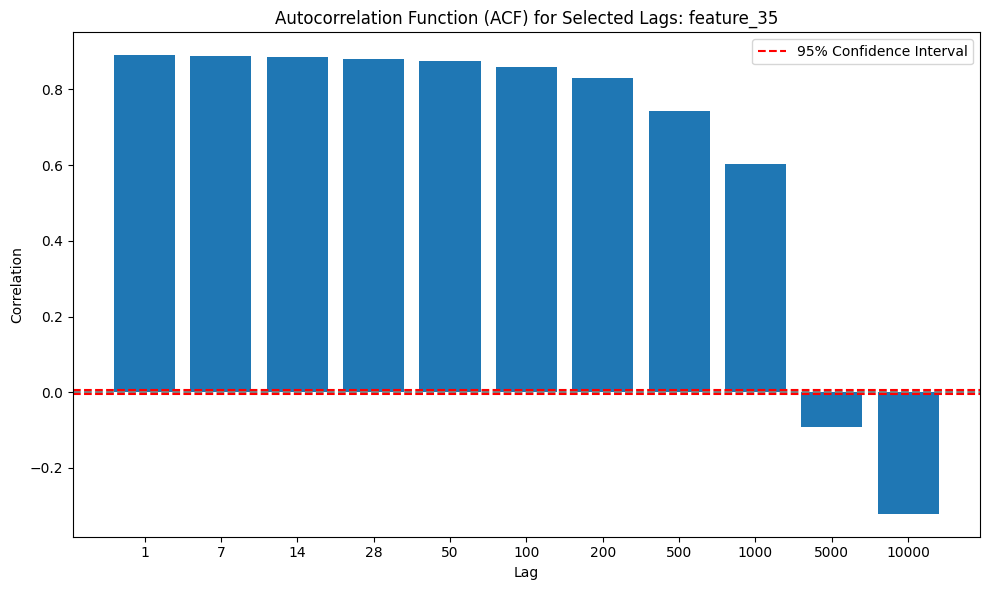

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


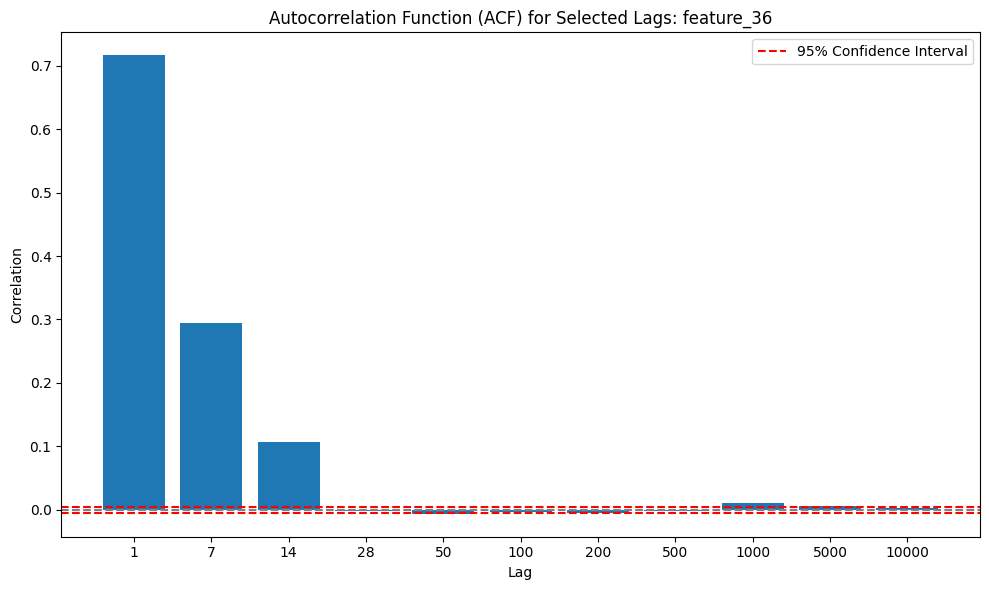

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


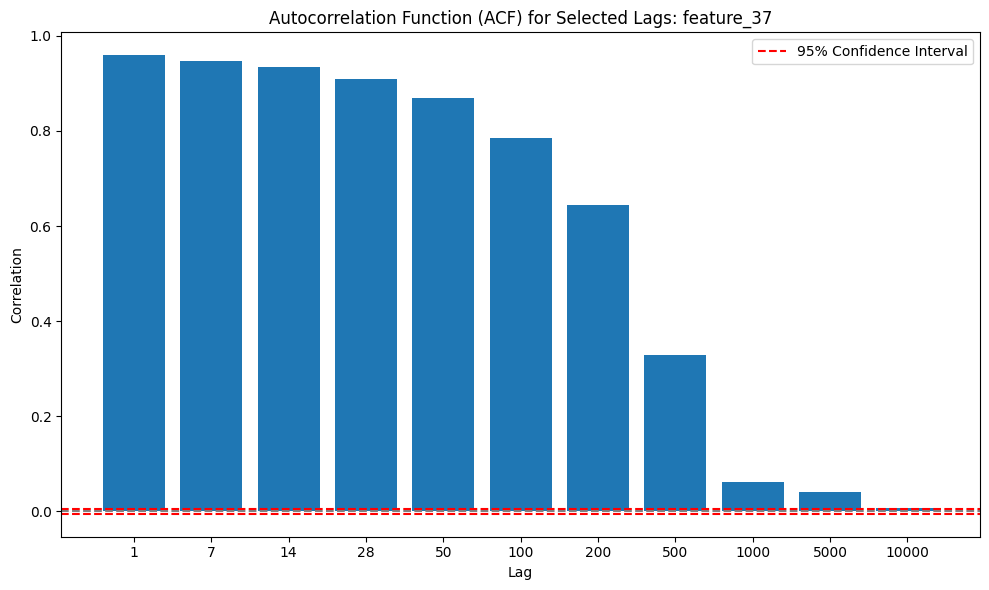

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


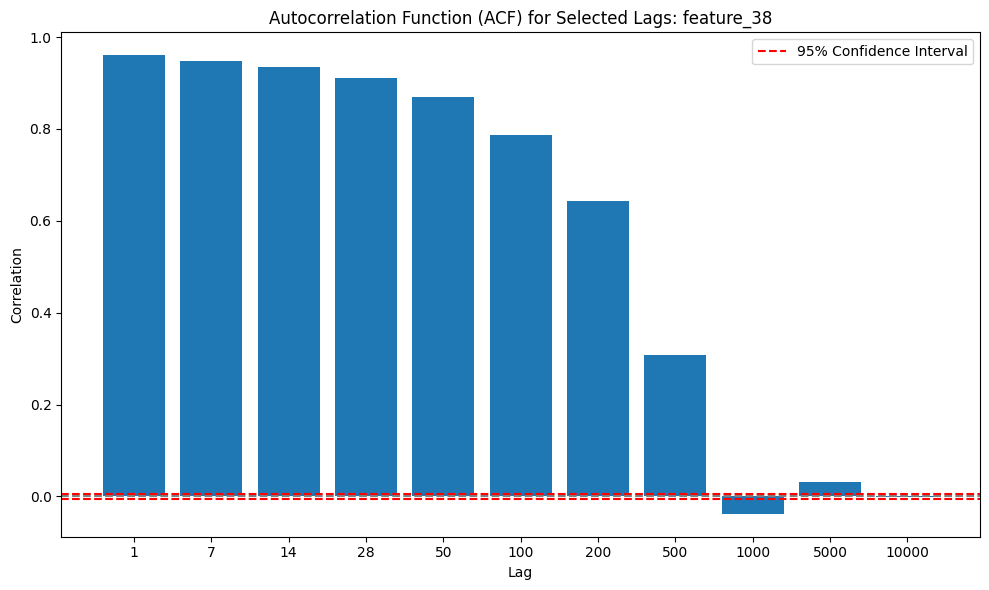

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


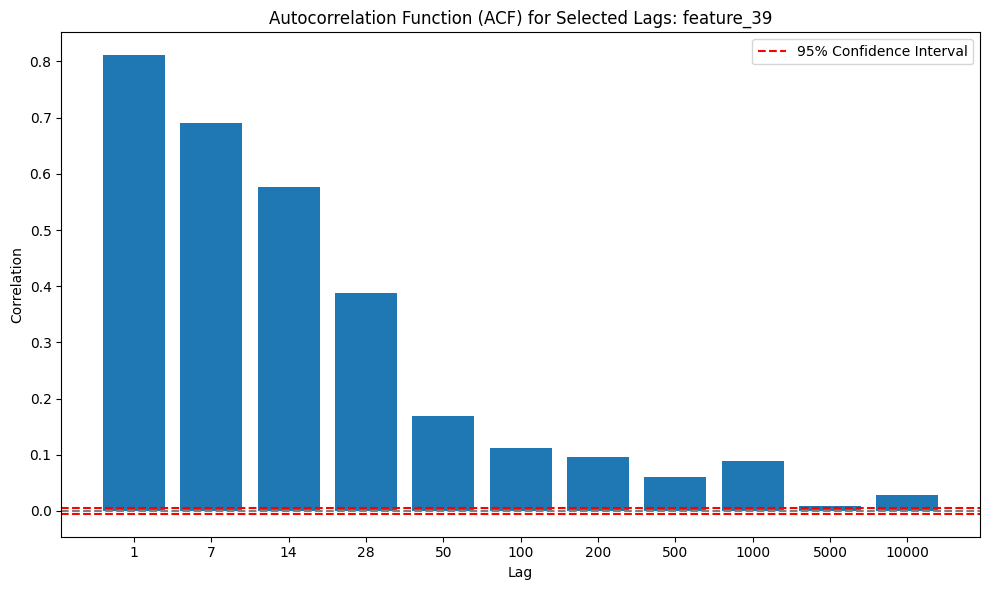

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


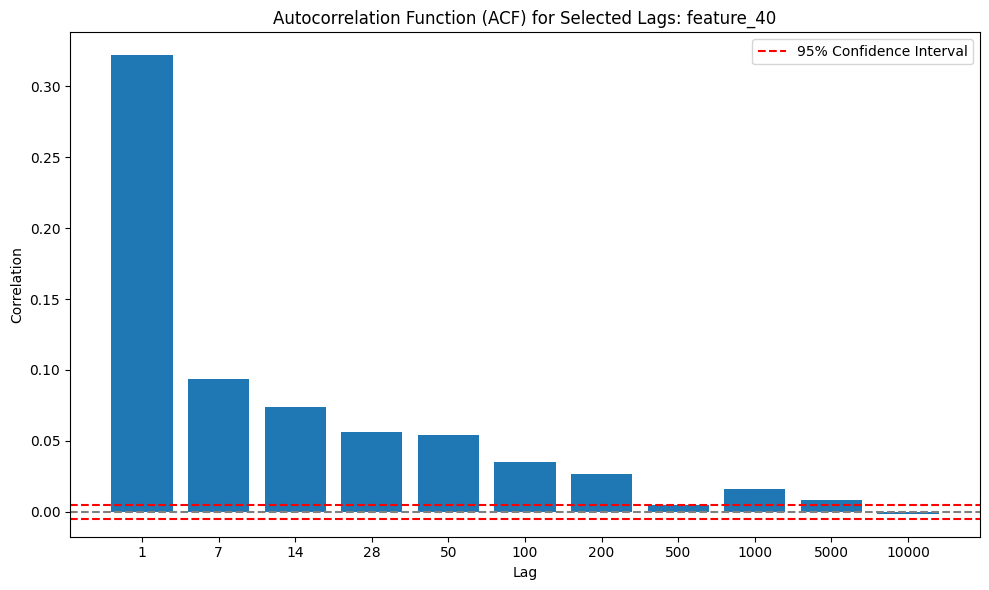

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


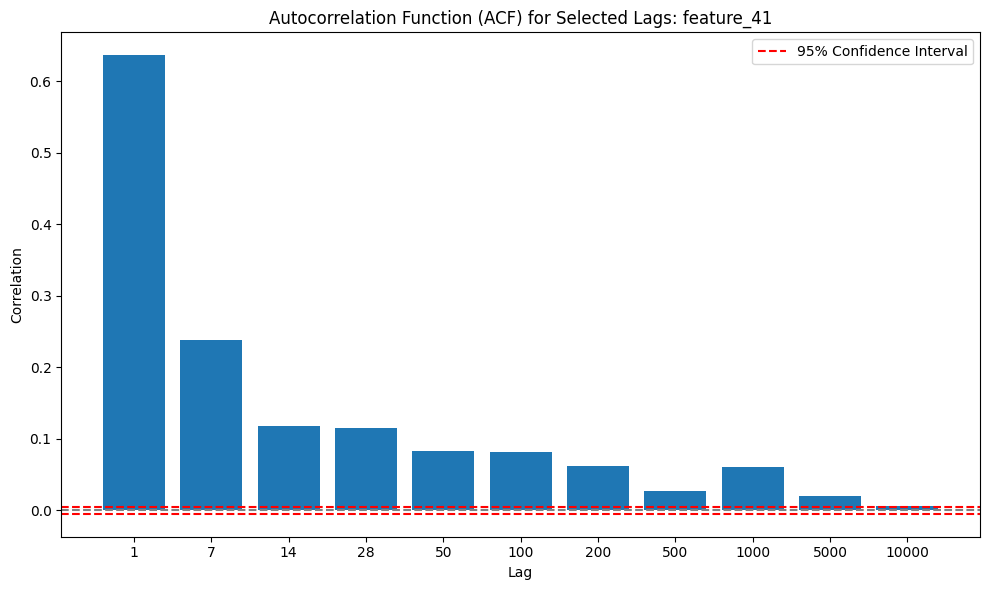

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


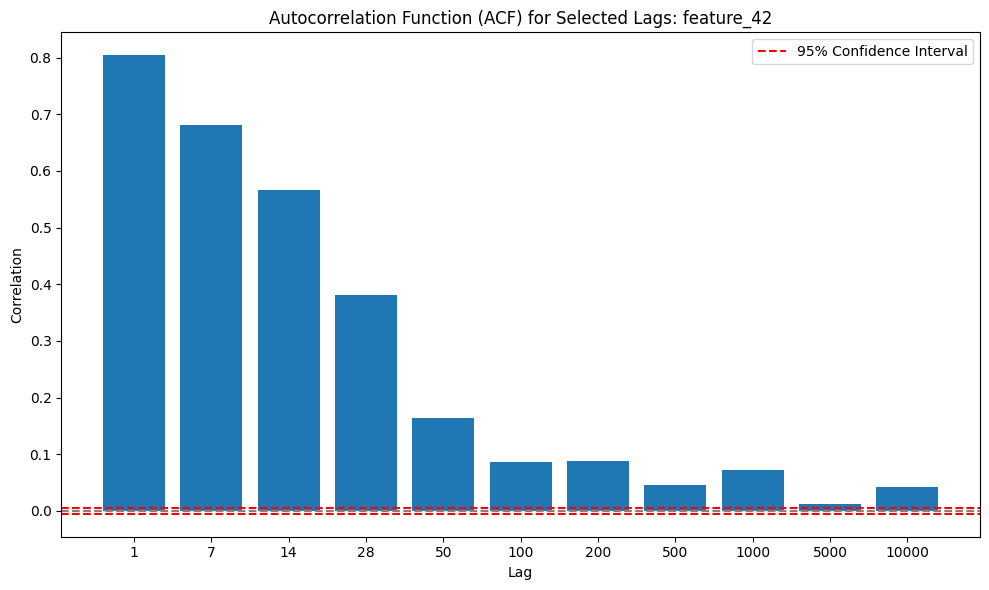

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


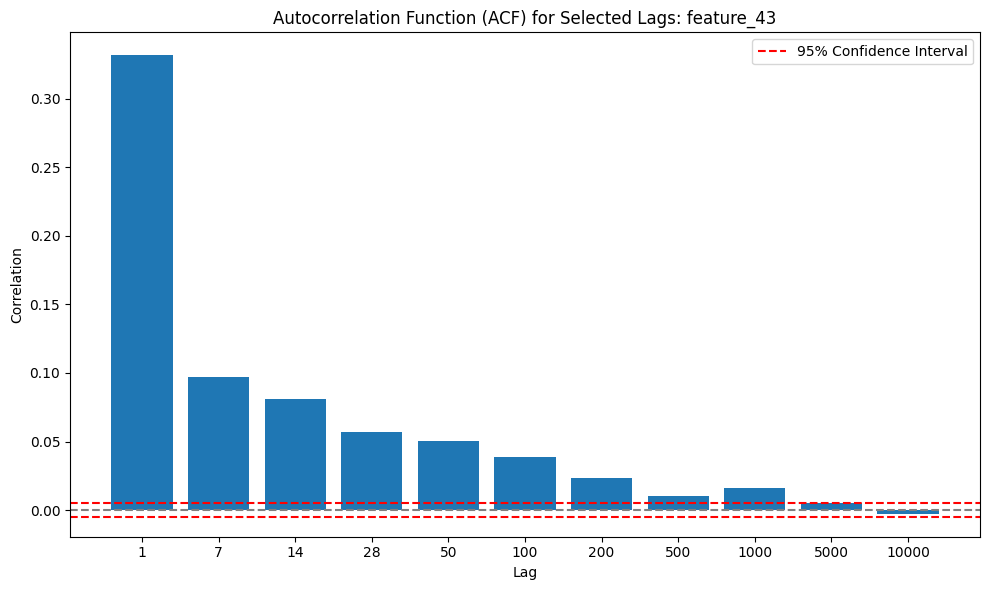

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


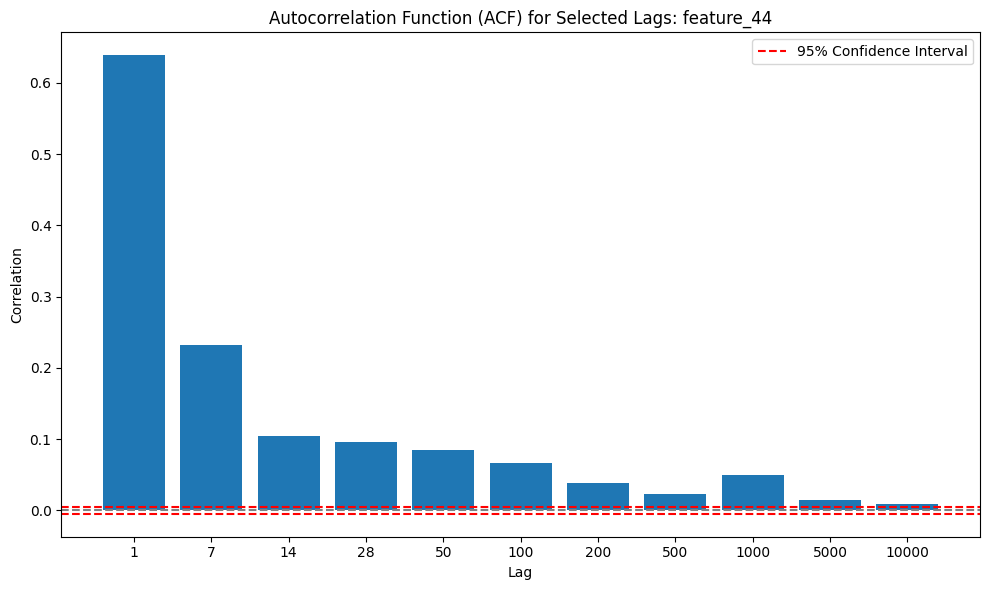

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


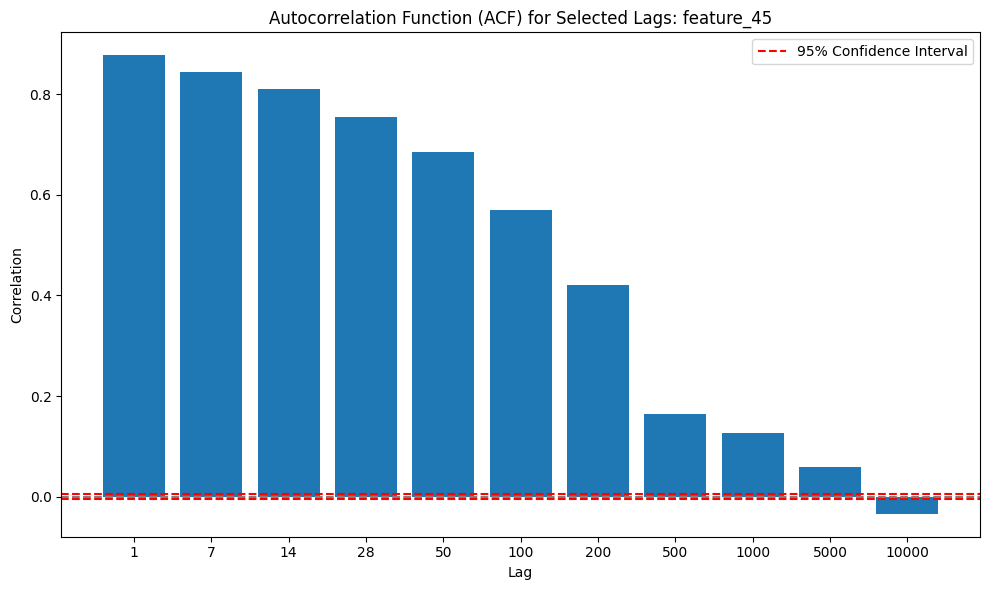

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


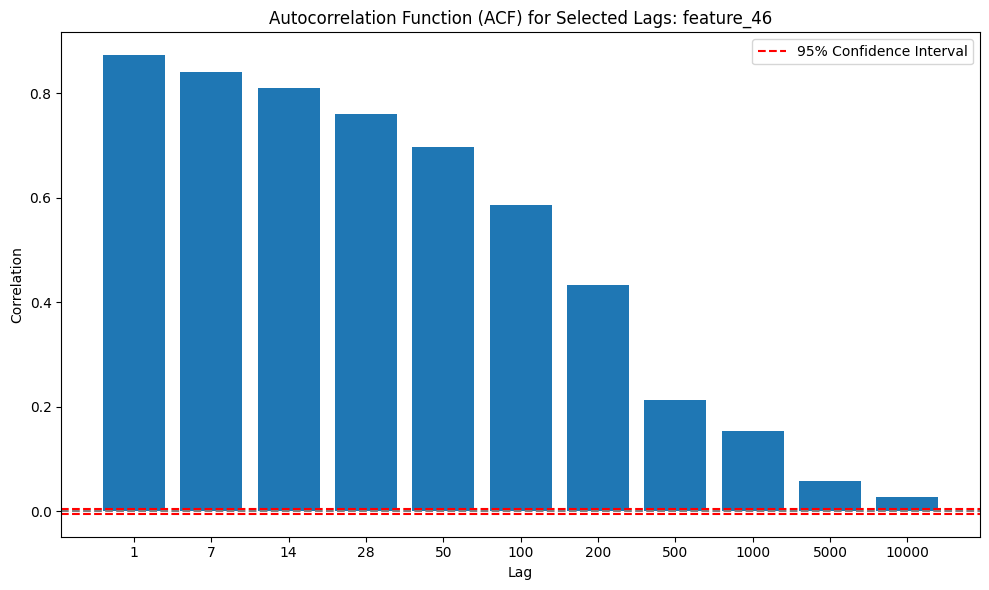

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


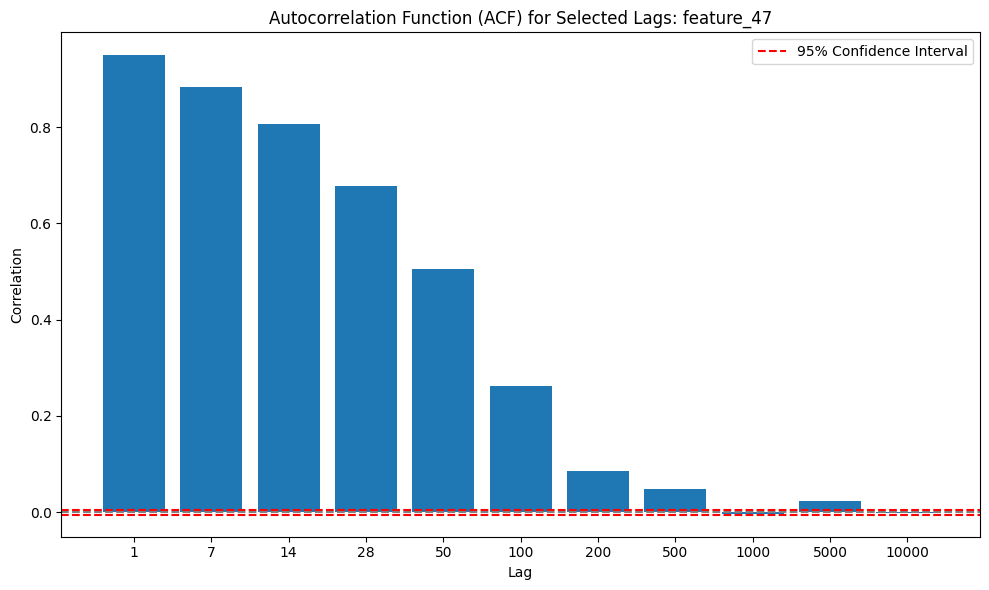

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


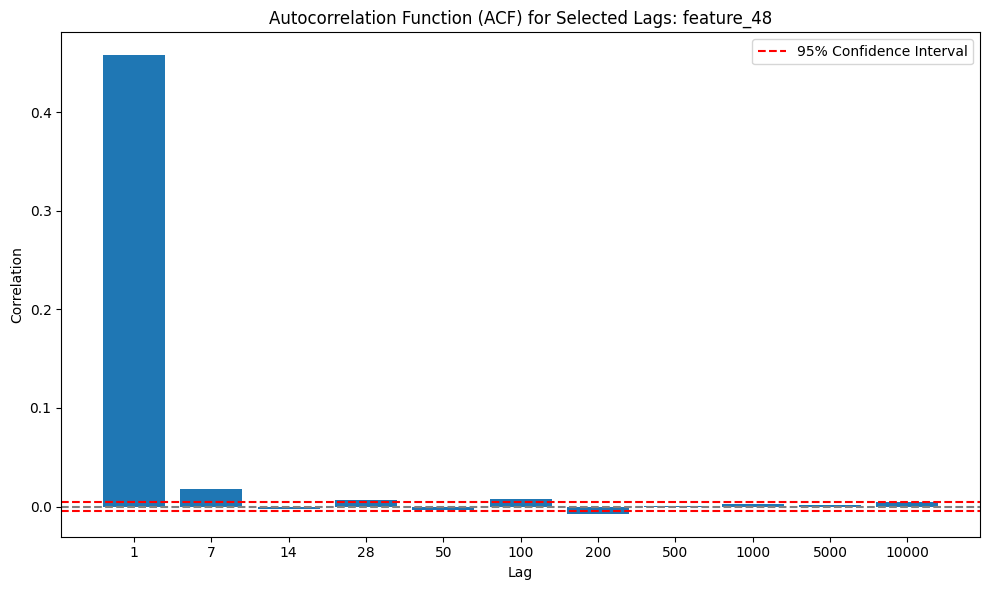

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


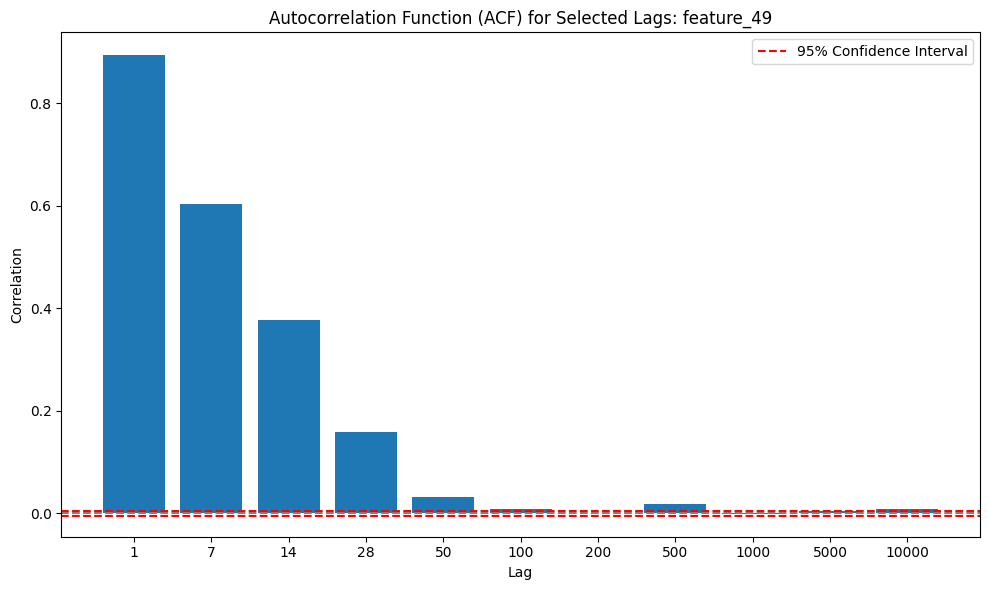

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


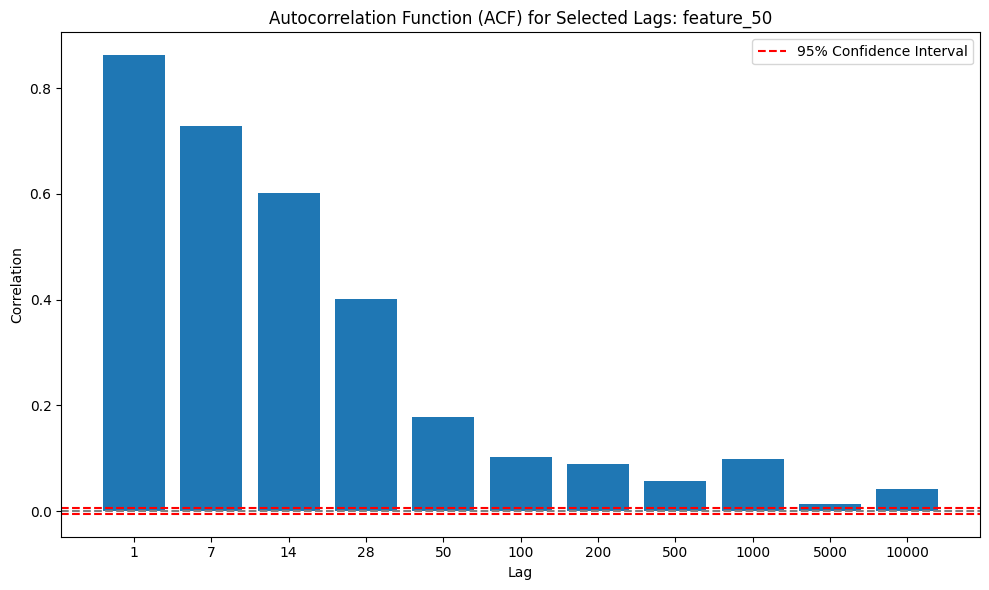

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


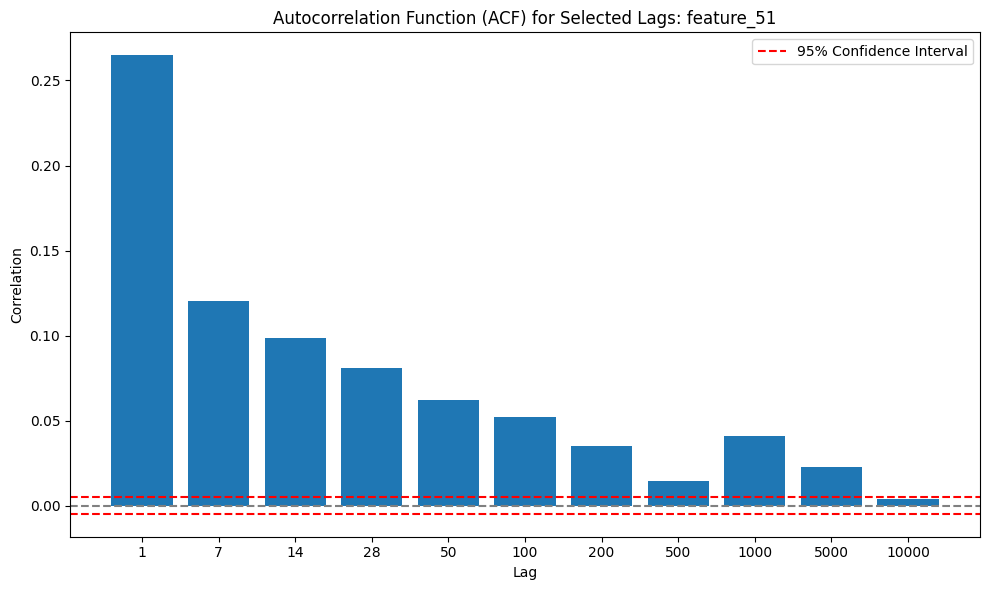

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


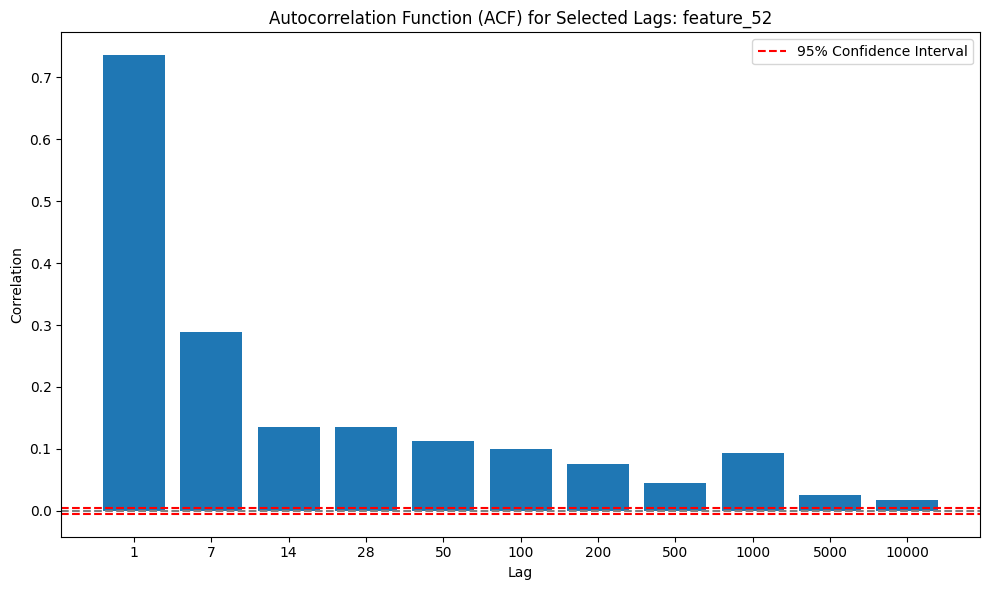

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


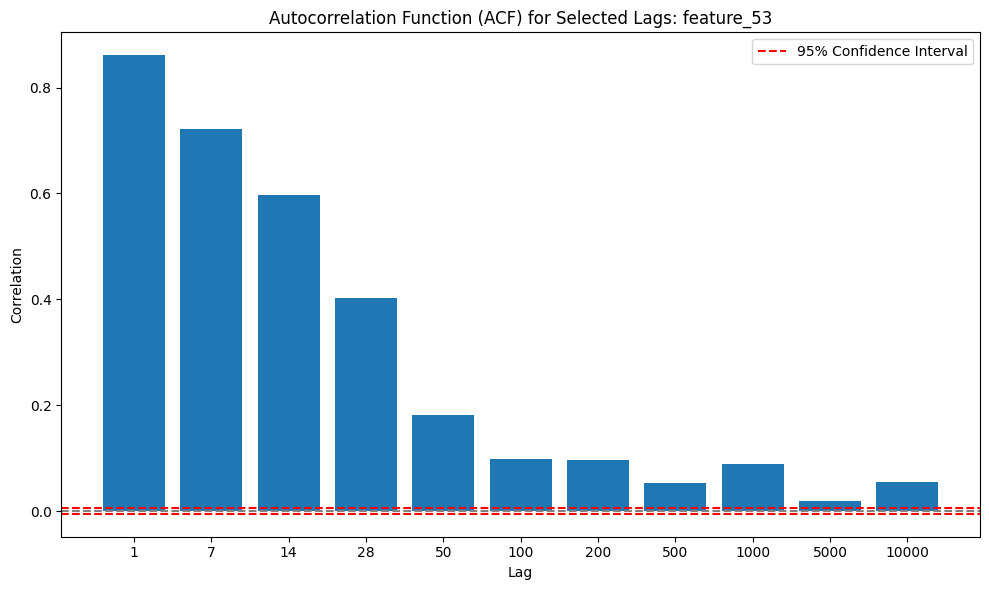

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


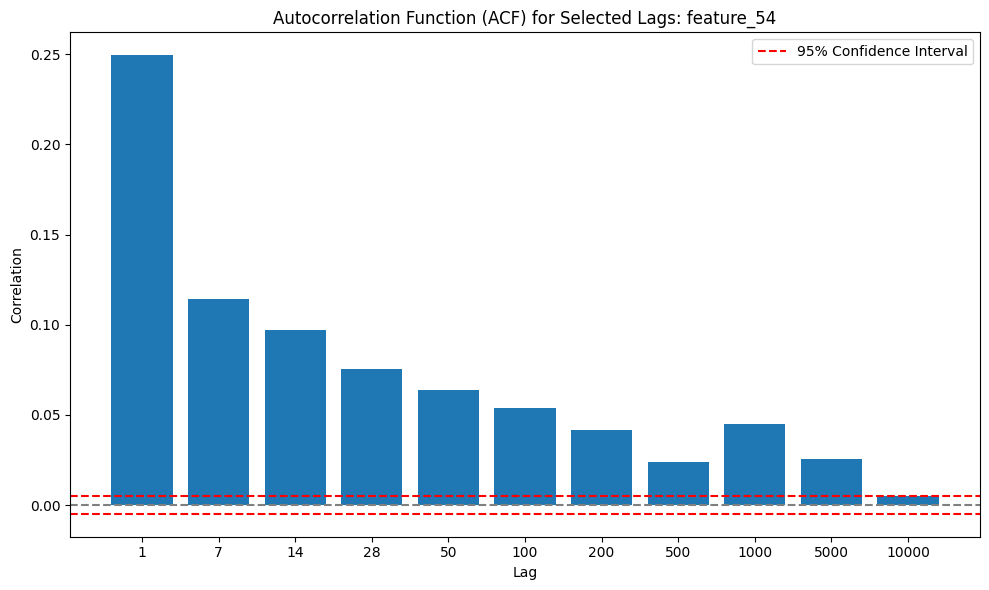

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


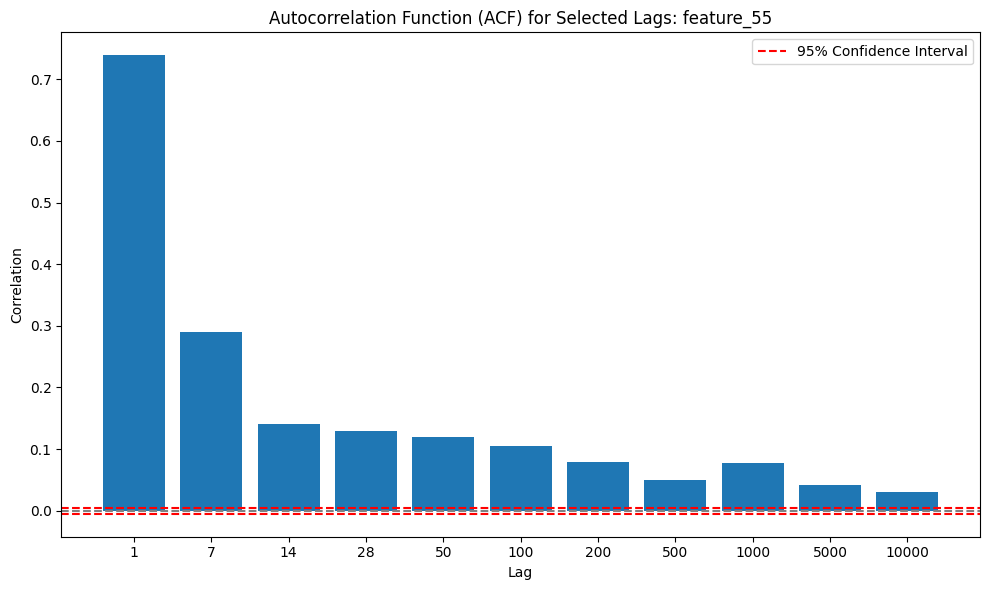

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


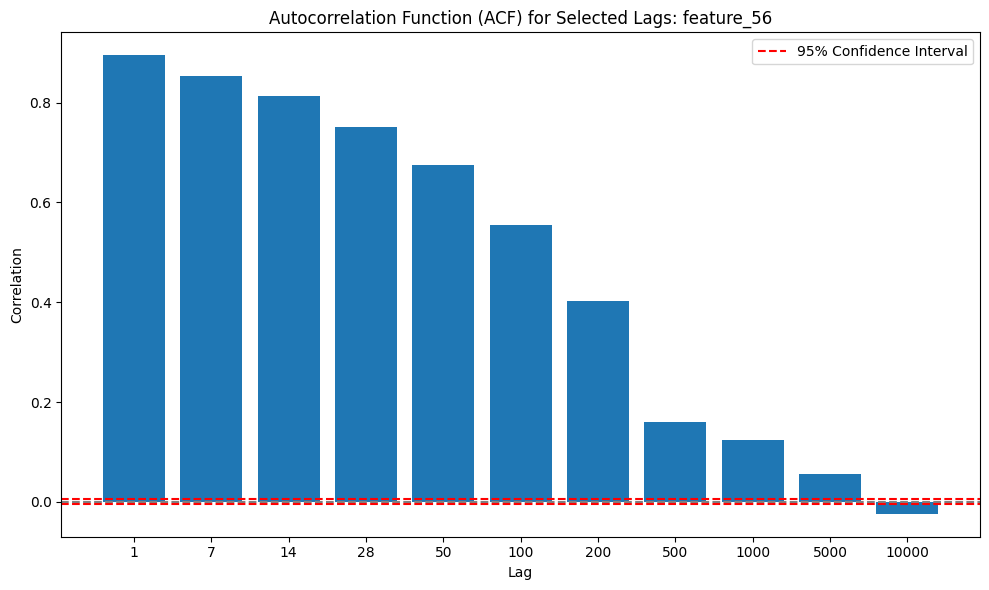

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


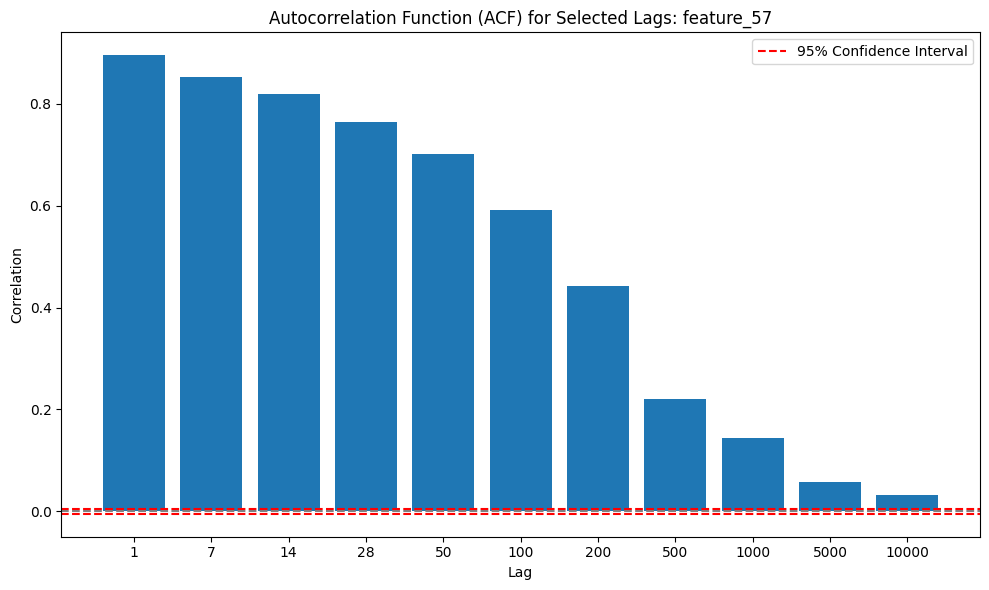

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


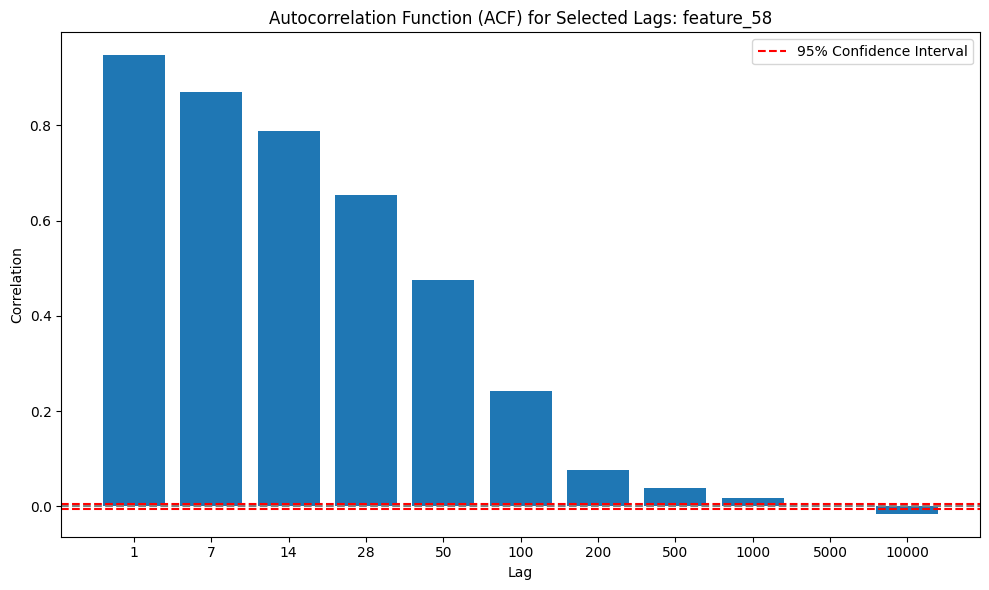

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


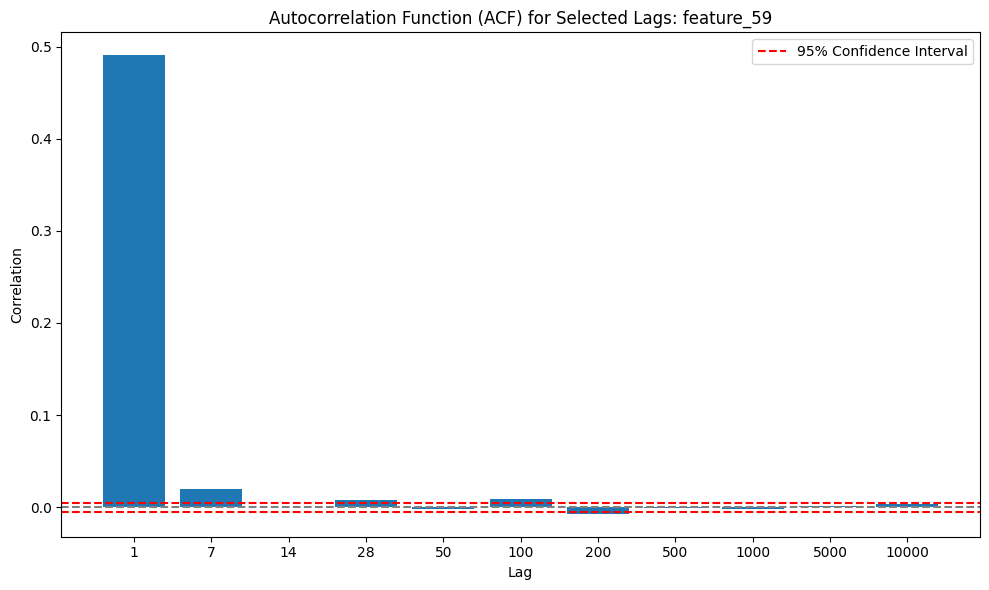

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


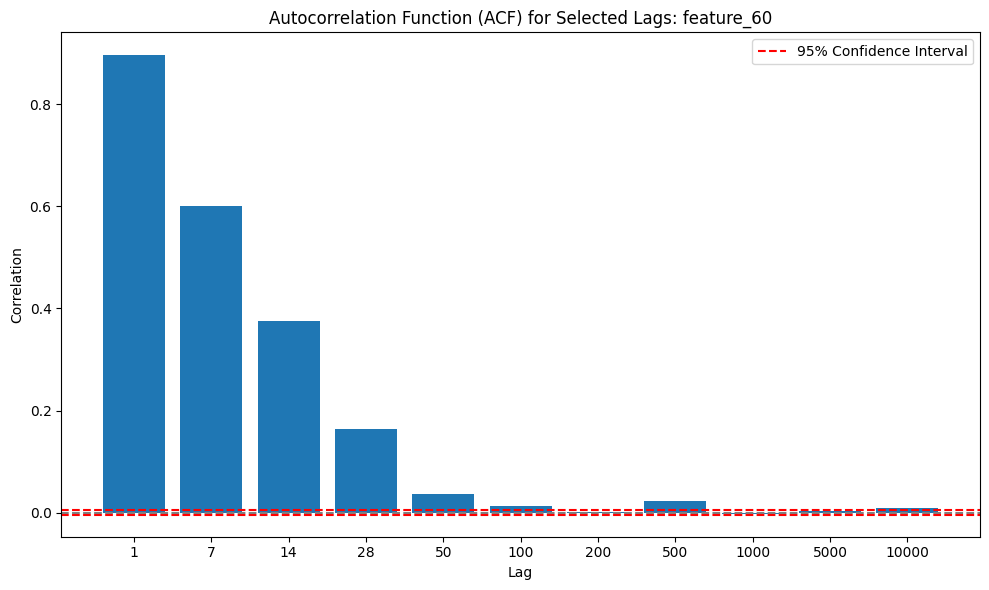

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


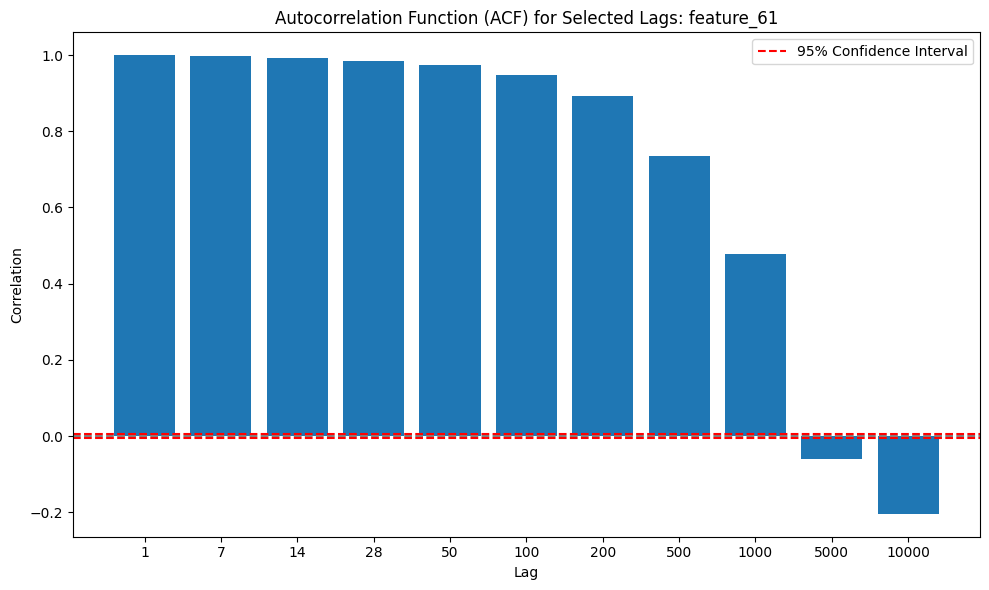

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


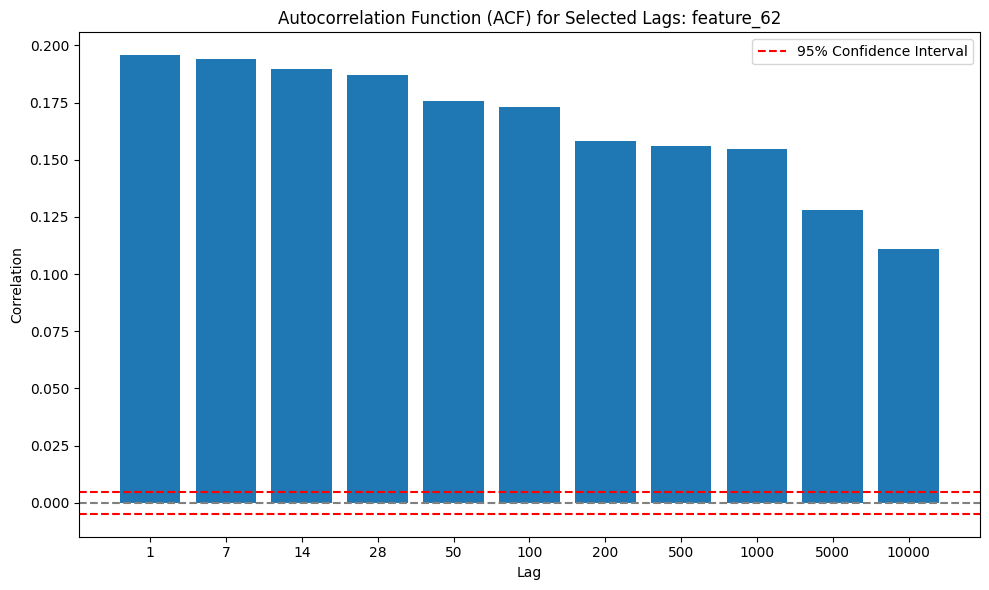

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


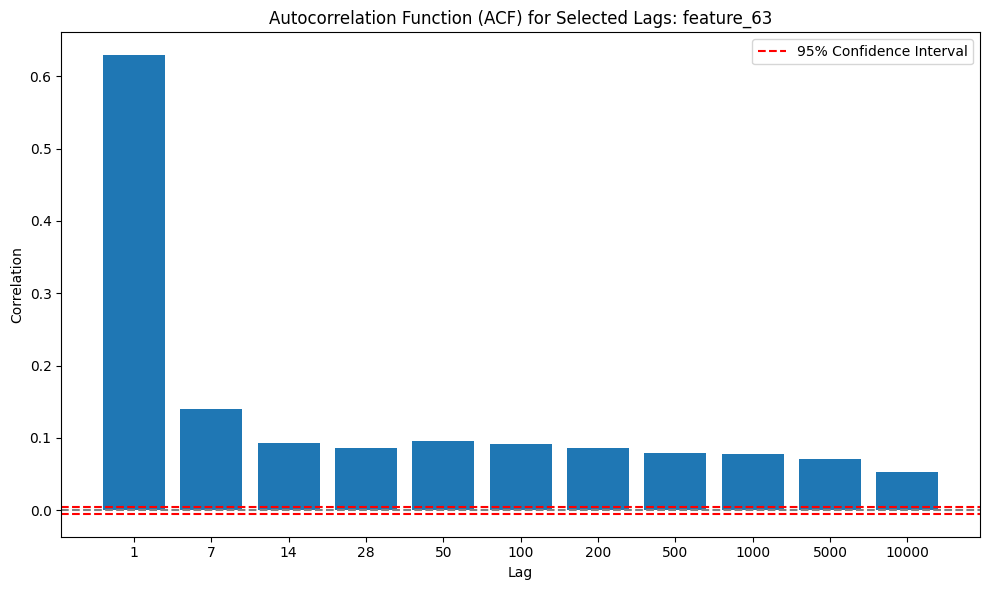

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


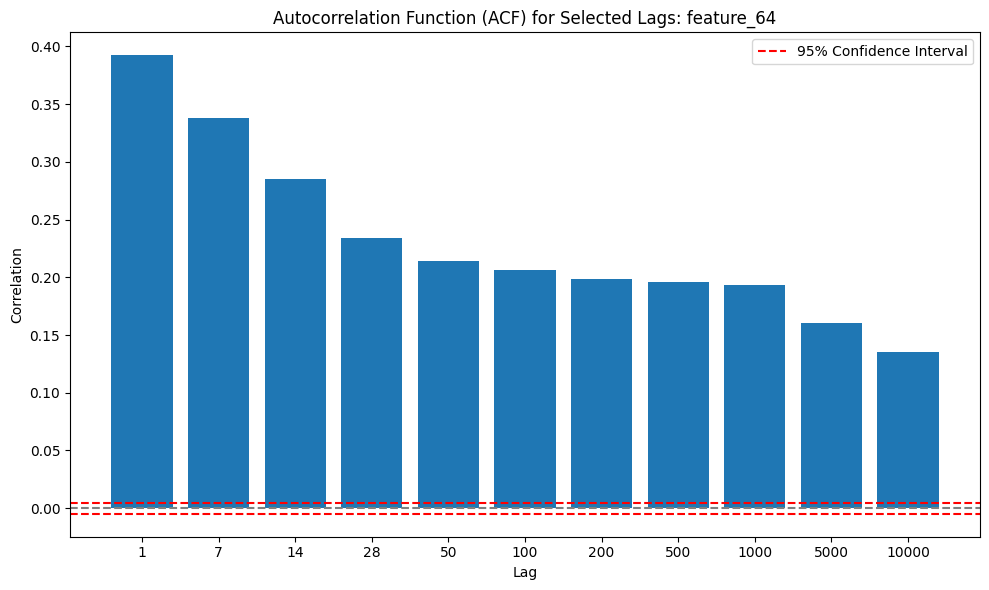

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


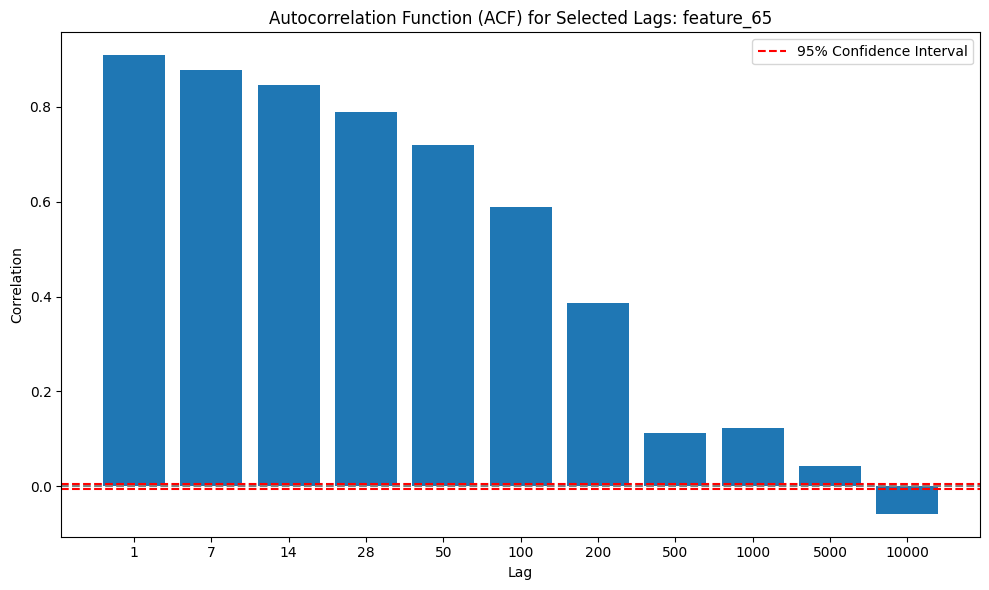

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


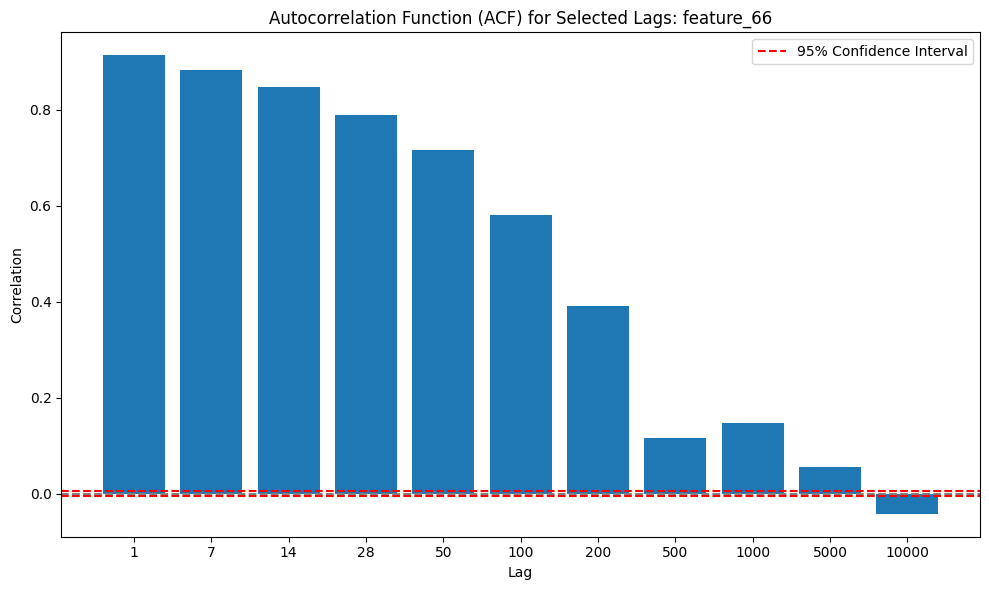

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


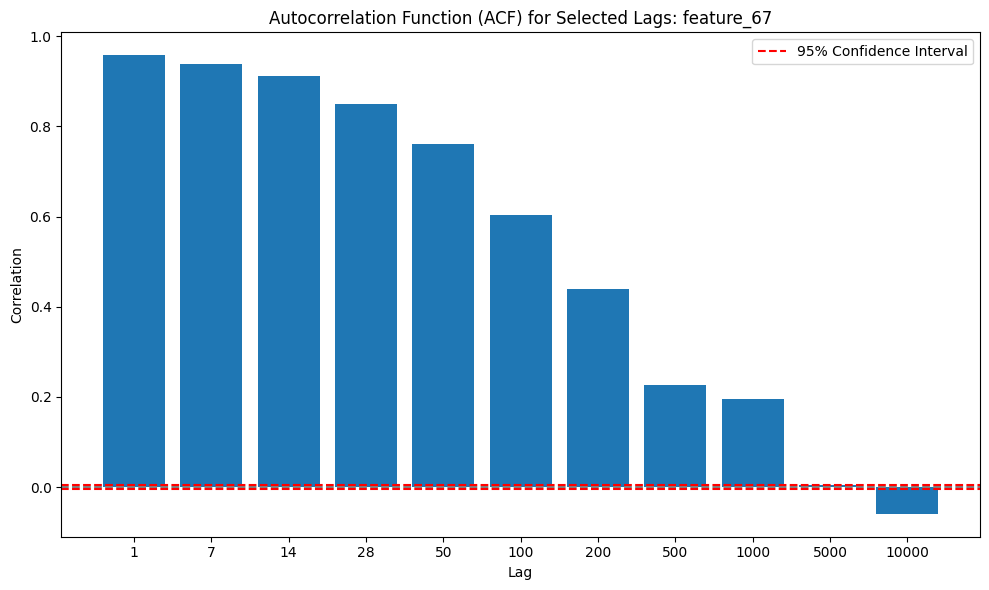

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


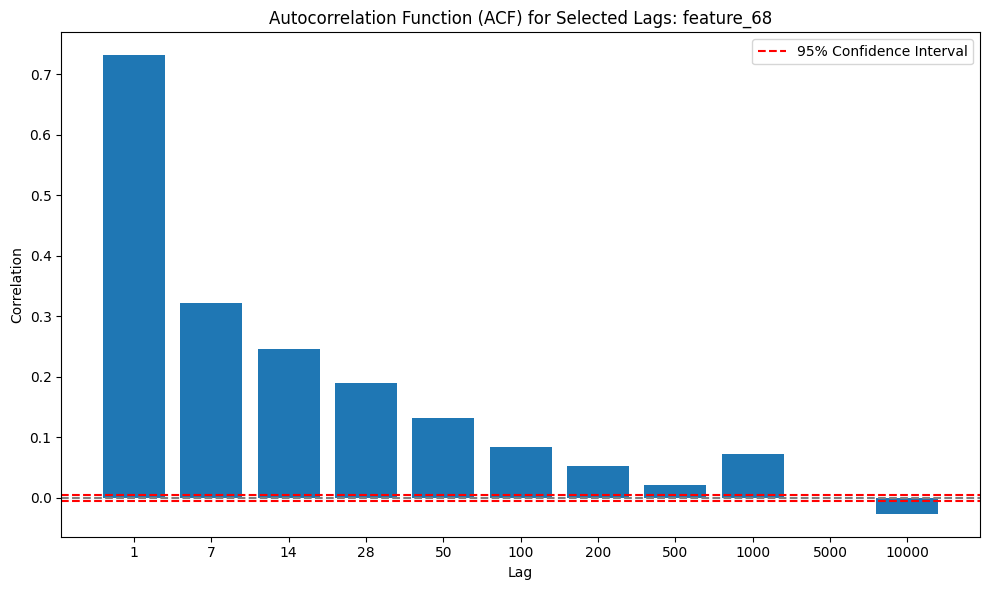

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


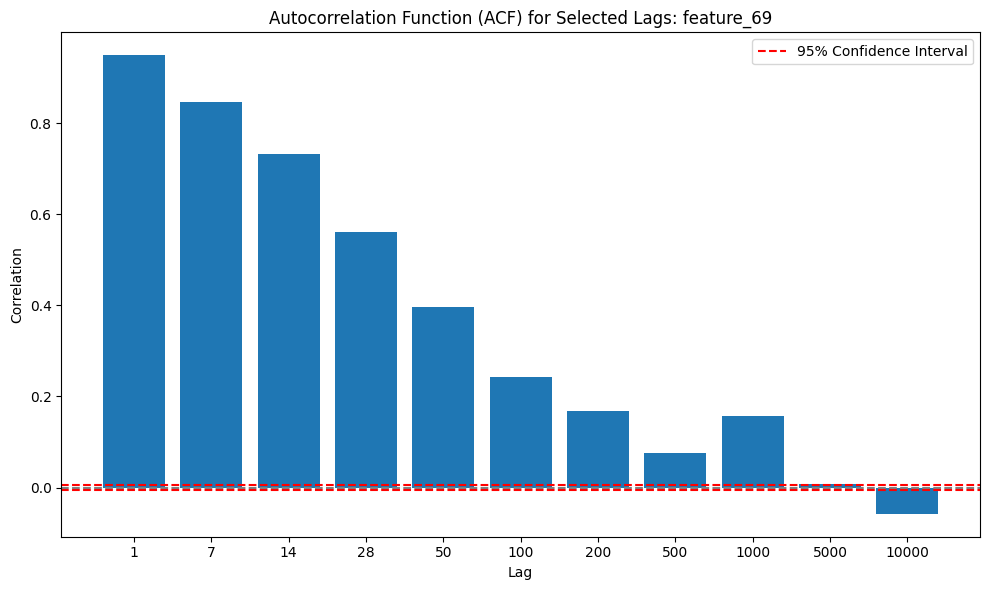

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


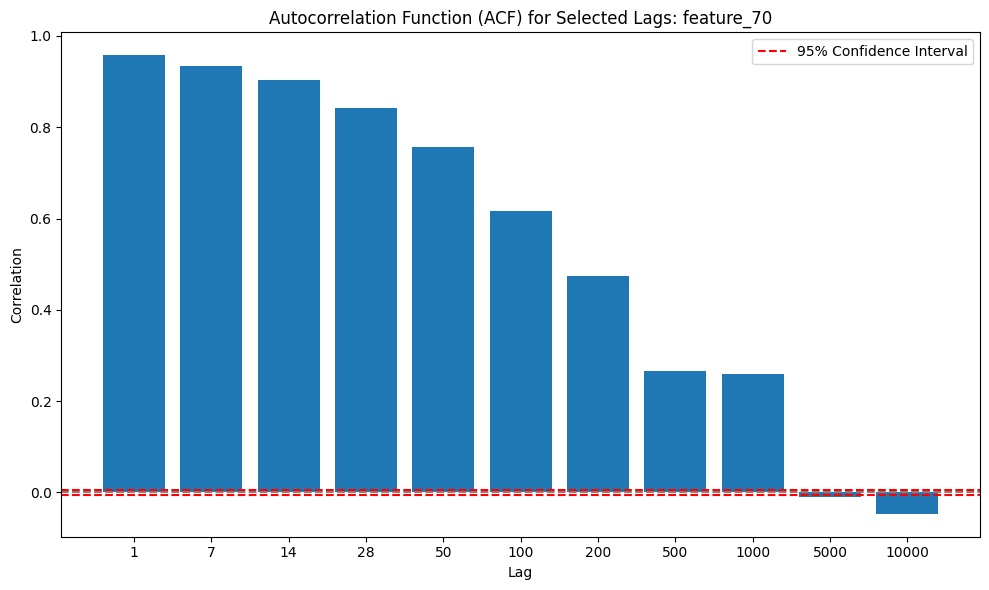

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


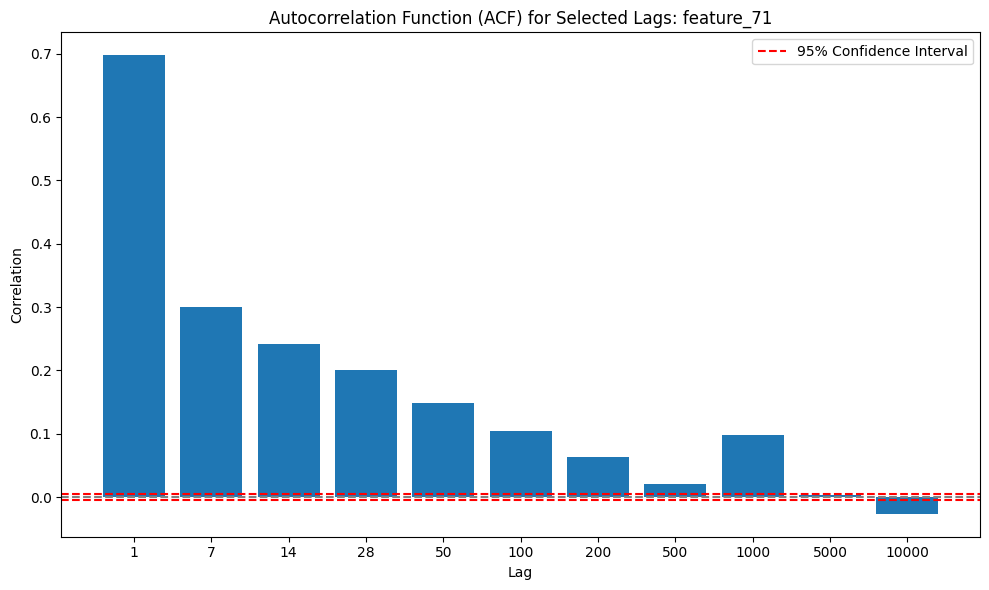

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


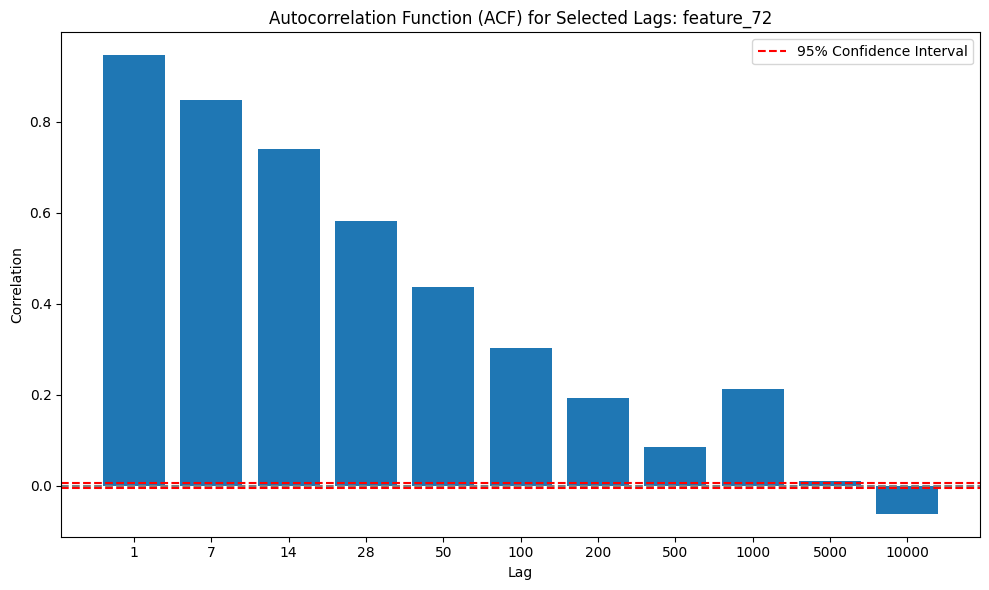

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


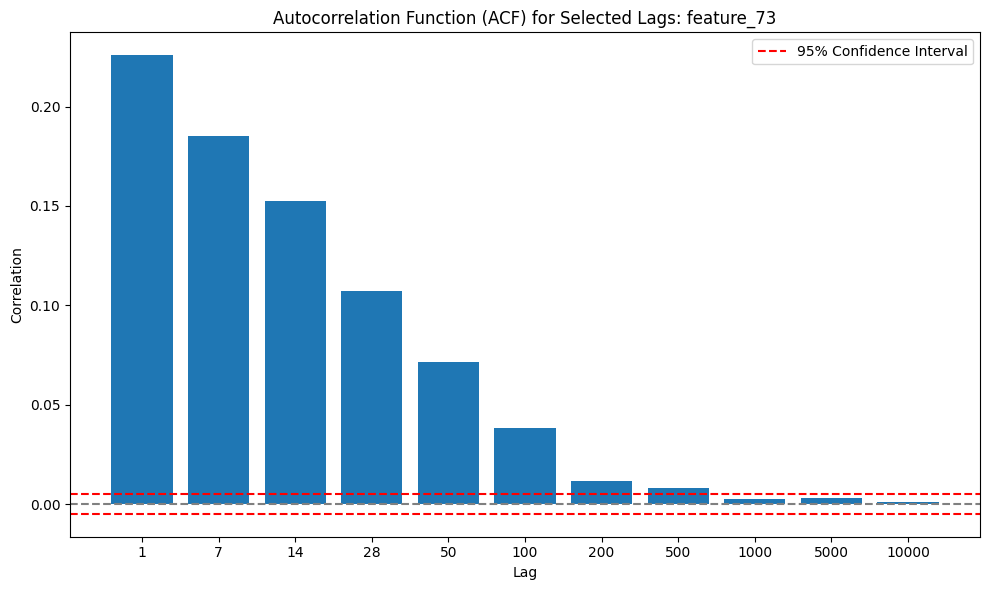

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


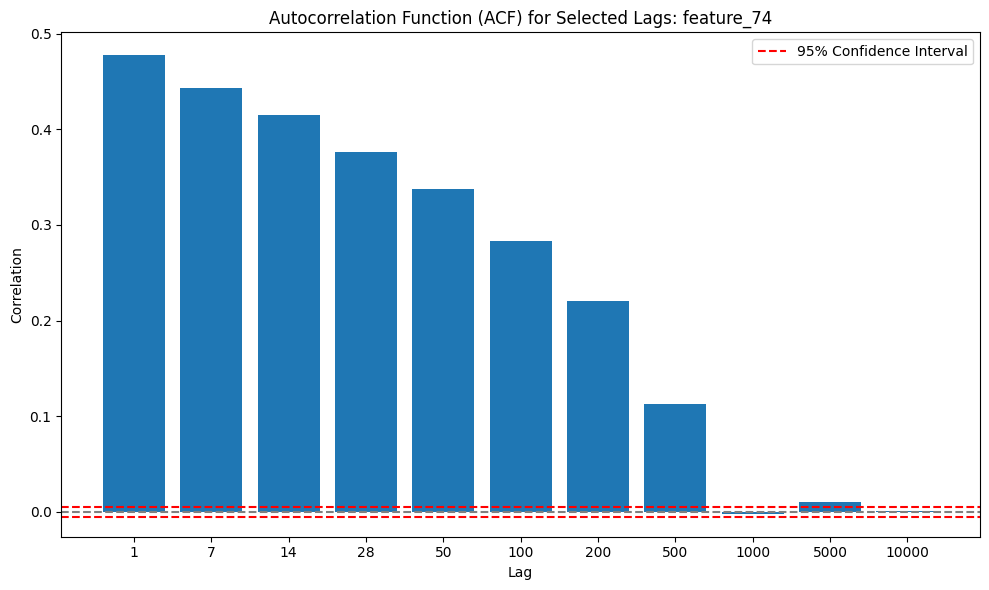

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


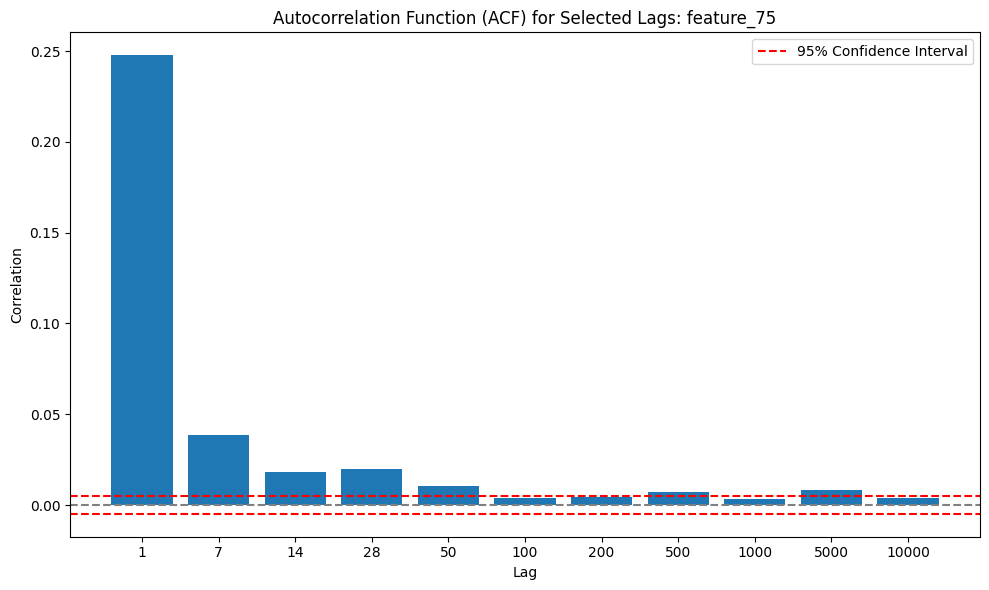

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


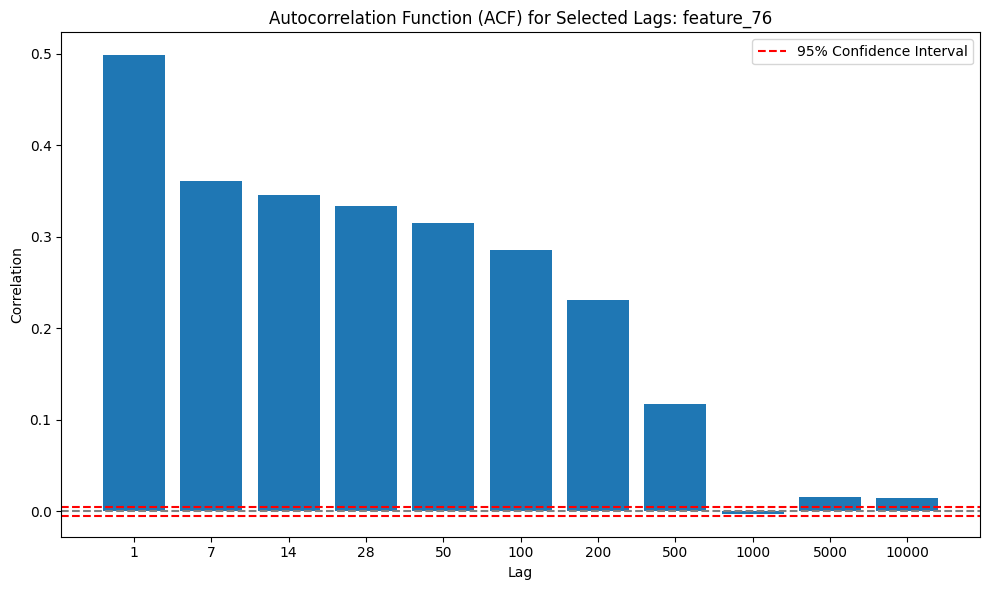

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


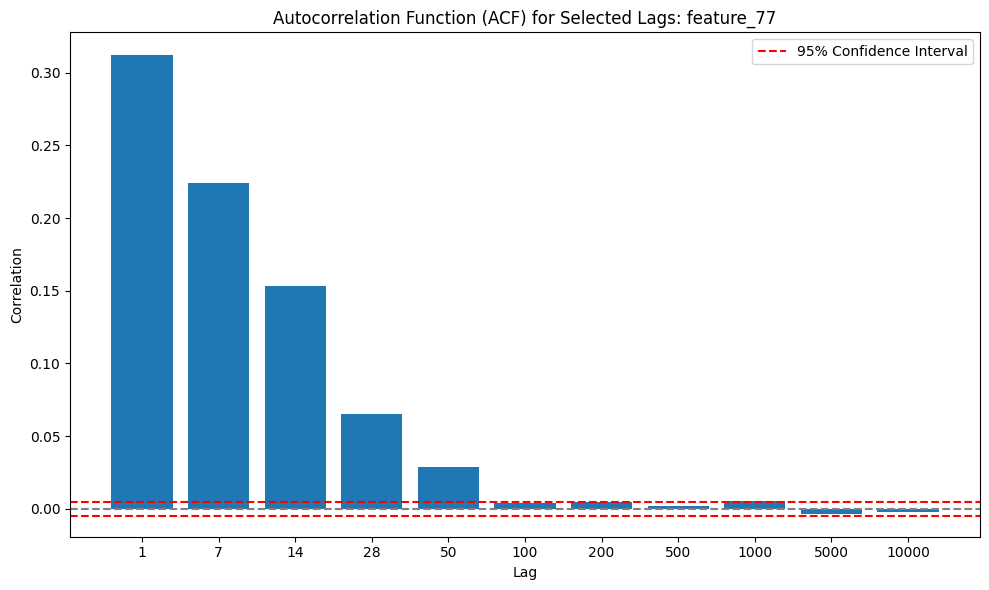

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


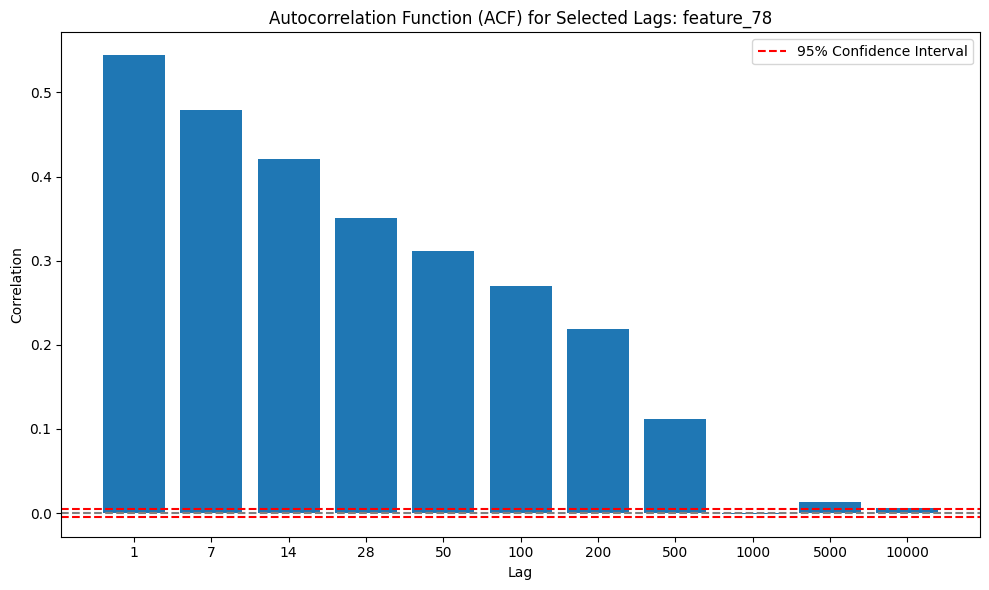

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


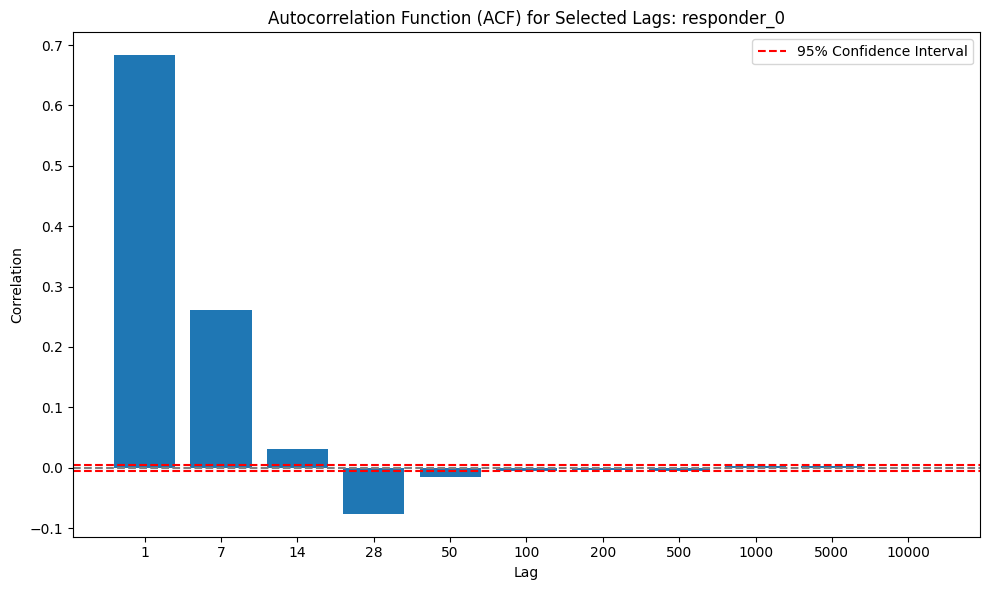

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


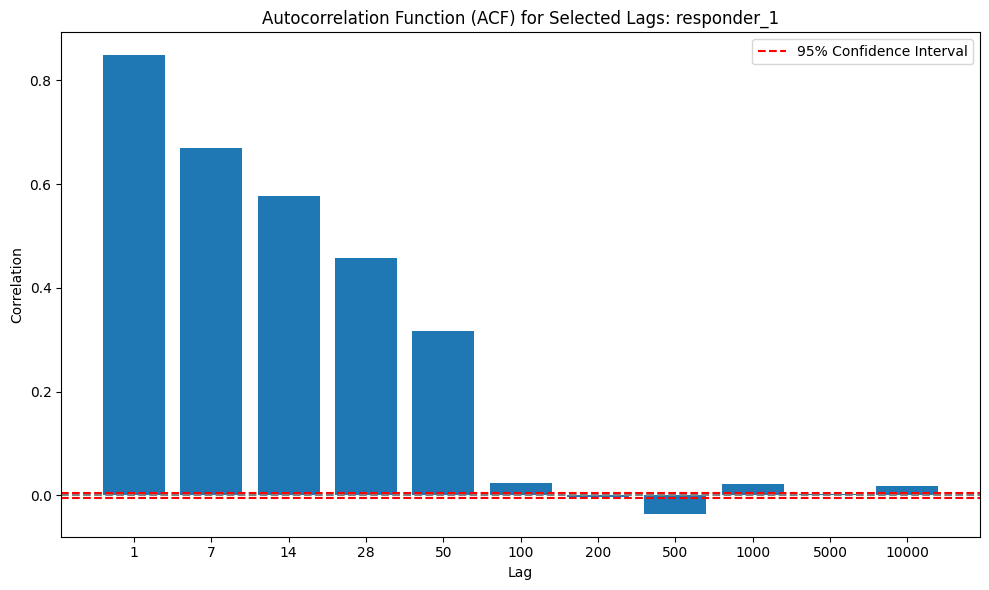

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


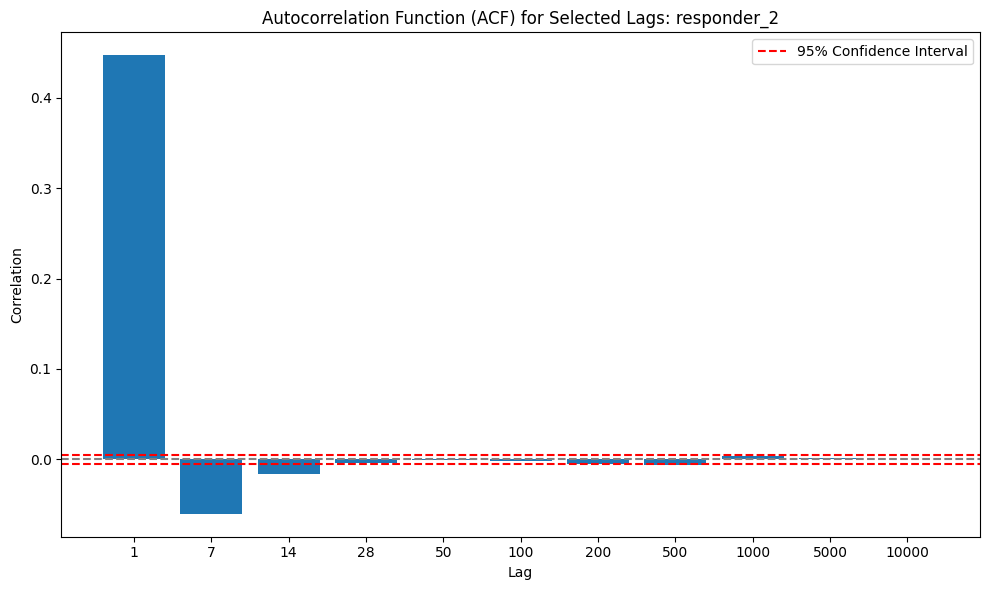

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


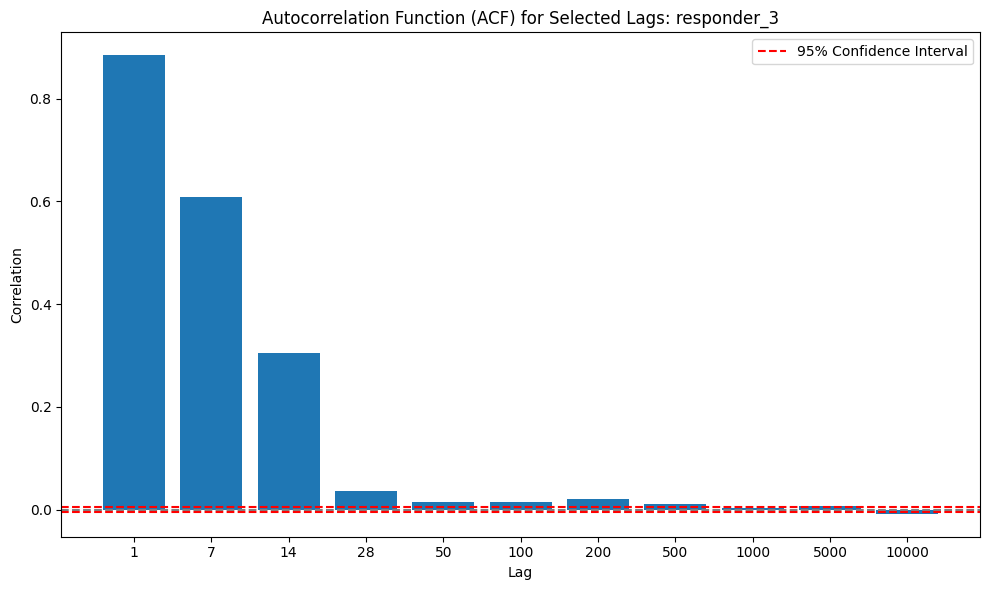

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


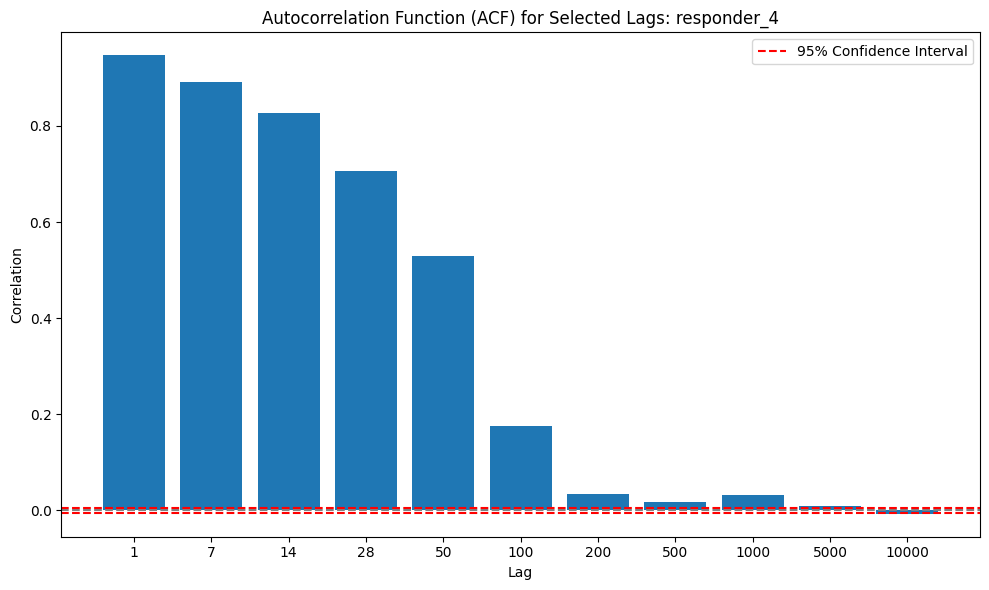

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


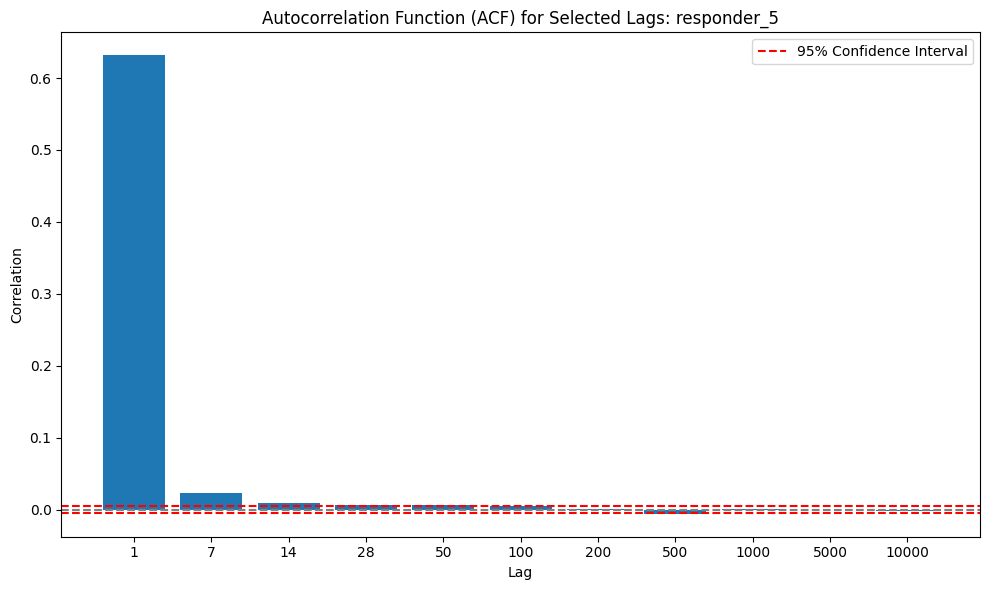

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


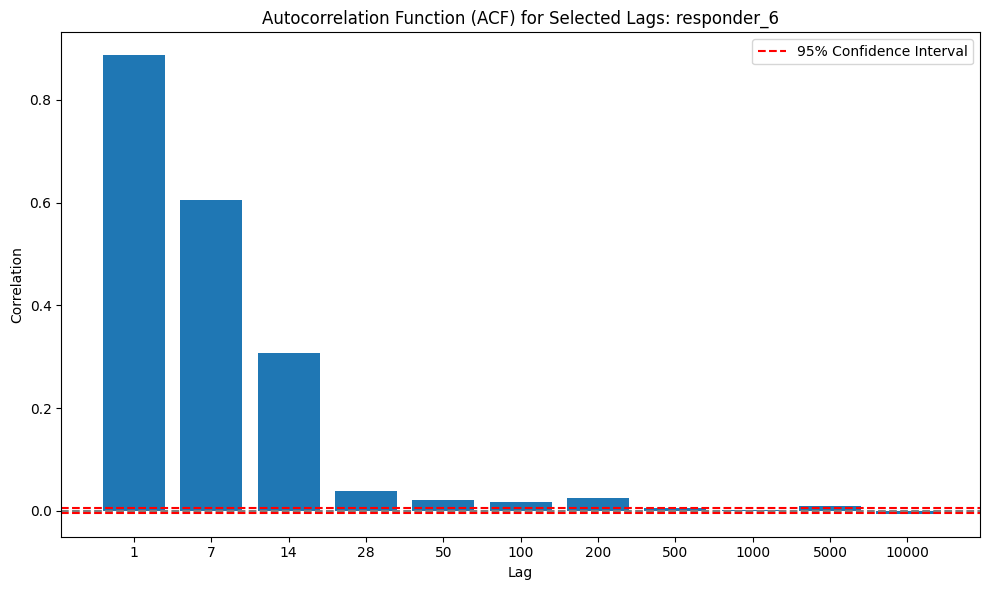

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


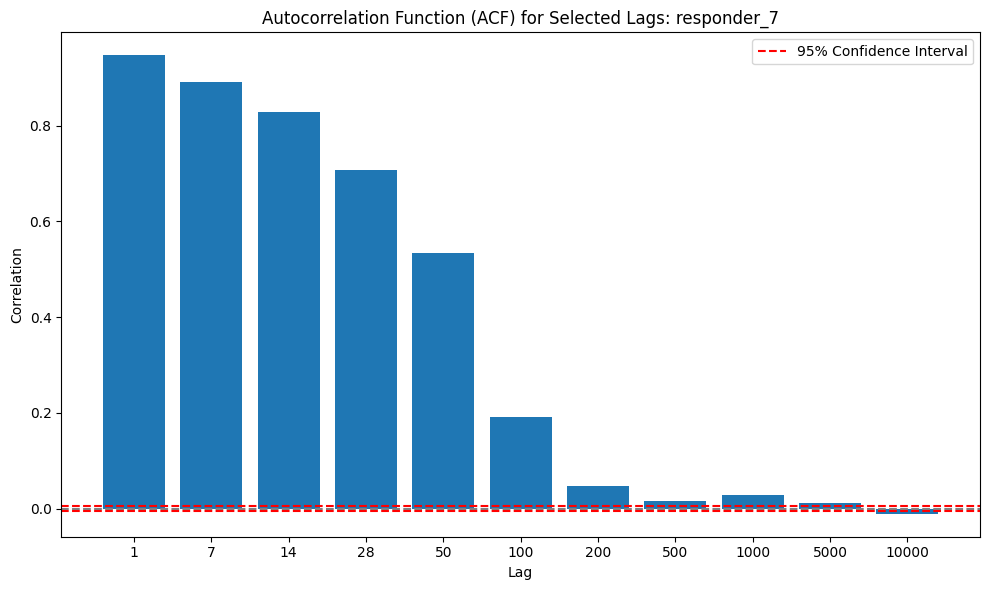

/tmp/ipykernel_272017/615931043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


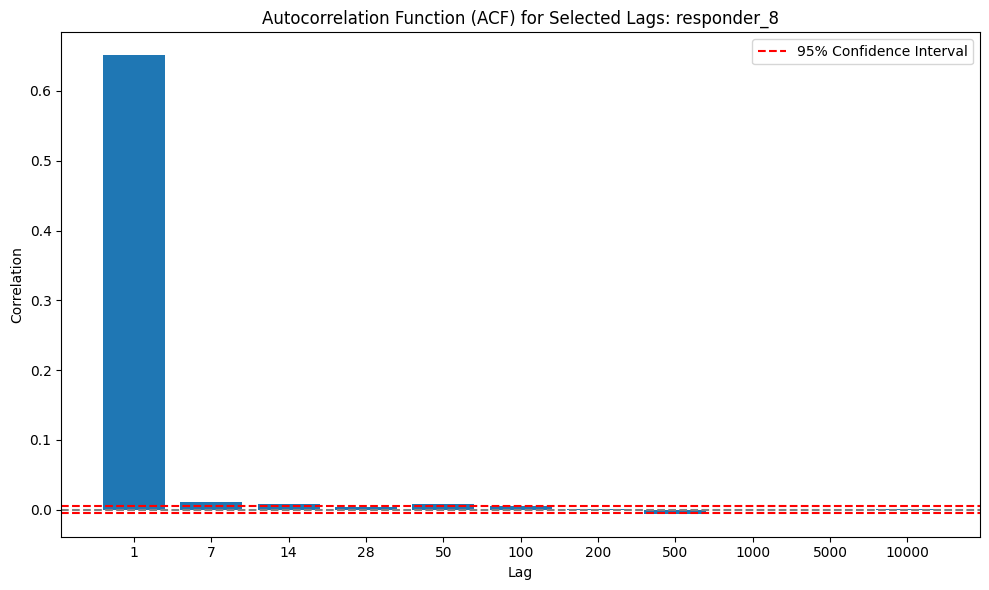

In [10]:
symbol_df = df[df['symbol_id']==1]

for col in symbol_df.columns:
    analyze_time_series(symbol_df[col], [1, 7, 14, 28, 50, 100, 200, 500, 1000, 5000, 10000], feature_name=col)